# K-Select notbook
This notebook conducts 2 parts:
1. K-Select algorithm.
2. Analysis of k across cities and years. 

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
from shapely import wkt
import os
import seaborn as sns
import matplotlib
# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']  # 可以替换为你喜欢的其他字体


## Filter out some cbgs which are water

In [3]:
#cbgs = gpd.read_file(r"D:\Dropbox\urban cup\arcgis project\cbgs\cbgs_of_cities\NewYork\New_York_city.shp")
cbgs = gpd.read_file(r"D:\Dropbox\urban cup\arcgis project\cbgs\cbgs_of_cities\NewYork\New_York_city.shp")
with open(r'D:\Dropbox\urban cup\data\Mobility\id_dict_1.pkl', 'rb') as f:
    id_dict = pickle.load(f)

print(cbgs.info())
print(len(id_dict.keys()))

# Extract the lines that not in cbgs but in id_dict
id_dict_keys = list(id_dict.keys())
id_dict_values = list(id_dict.values())
cbgs_keys = list(cbgs['CBG_Code'].values)
not_in_cbgs = []
count = 0
for i in id_dict_keys:
    if id_dict[id_dict_keys[i]] not in cbgs_keys:
        not_in_cbgs.append(i)
        count += 1
not_in_cbgs

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6285 entries, 0 to 6284
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   City_Name   6285 non-null   object  
 1   CBG_Code    6285 non-null   float64 
 2   Year        6285 non-null   float64 
 3   Population  6285 non-null   float64 
 4   Area        6285 non-null   float64 
 5   Centroid    6285 non-null   object  
 6   Shape_Leng  6285 non-null   float64 
 7   Shape_Area  6285 non-null   float64 
 8   geometry    6285 non-null   geometry
dtypes: float64(6), geometry(1), object(2)
memory usage: 442.0+ KB
None
6493


[295,
 333,
 480,
 483,
 498,
 500,
 503,
 506,
 535,
 546,
 550,
 552,
 555,
 558,
 559,
 561,
 586,
 589,
 613,
 628,
 633,
 634,
 635,
 639,
 649,
 653,
 654,
 656,
 683,
 700,
 741,
 745,
 747,
 748,
 750,
 770,
 771,
 820,
 845,
 850,
 852,
 854,
 857,
 861,
 868,
 869,
 874,
 901,
 911,
 916,
 918,
 919,
 922,
 961,
 1050,
 1077,
 1169,
 1177,
 1180,
 1186,
 1195,
 1216,
 1221,
 1233,
 1242,
 1245,
 1252,
 1253,
 1279,
 1367,
 1393,
 1568,
 1575,
 1583,
 1585,
 1590,
 1592,
 1600,
 1602,
 1737,
 1877,
 1878,
 2038,
 2039,
 2069,
 2076,
 2077,
 2157,
 2162,
 2170,
 2192,
 2201,
 2204,
 2206,
 2207,
 2209,
 2210,
 2436,
 2473,
 2475,
 2477,
 2480,
 2481,
 2681,
 2683,
 2686,
 2706,
 2712,
 2813,
 3135,
 3161,
 3293,
 3294,
 3412,
 3416,
 3455,
 3673,
 3729,
 3790,
 4077,
 4083,
 4084,
 4169,
 4170,
 4171,
 4174,
 4181,
 4452,
 4583,
 4815,
 4832,
 4834,
 4839,
 4841,
 4844,
 4845,
 4847,
 4851,
 4854,
 4884,
 4886,
 4888,
 4890,
 4957,
 4960,
 4963,
 5003,
 5011,
 5019,
 5044,
 506

## K-Select algorithm.

In [15]:
# The algorithm to find the smallest k such that the subgraph remains strongly connected
# The binary search algorithm is used in finding the smallest k
# Input: flow_matrix: numpy array of flow matrix
# Output: k: the smallest k such that the subgraph remains strongly connected

import numpy as np
import networkx as nx
import pandas as pd

def minimum_flows_for_strongly_connectivity(flow_matrix):
    """The algorithm to find the smallest k such that the subgraph remains strongly connected.
        The binary search algorithm is used in finding the smallest k
    Args:
        flow_matrix (ndarray): numpy array of flow matrix

    Returns:
        k: the smallest k such that the subgraph remains strongly connected.
        
    Usage:
        flow_matrix = np.load(r'data\Mobility\cbg_visit_2022-02_7.npy')
        k=minimum_flows_for_strongly_connectivity(flow_matrix)
        print(f"The smallest k such that the subgraph remains strongly connected is {k}.")
    """    
    # Set the diagonal elements to zero
    np.fill_diagonal(flow_matrix, 0)

    # Create directed graph from flow matrix
    G = nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

    # Find all strongly connected components
    scc = list(nx.strongly_connected_components(G))

    # Create a subgraph with only nodes in the first SCC
    sub_G = G.subgraph(max(scc, key=len))
    print("nodes of the largest strongly connected graph for city:", len(sub_G.nodes()))
    num_units = len(sub_G.nodes())

    # Function to check if the graph is strongly connected when only top k edges are kept for each node
    def check_strongly_connected_k(graph, k):
        # Create a new graph which only keeps top k outgoing edges for each node
        new_graph = nx.DiGraph()
        for node in graph.nodes():
            edges = sorted(graph.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
            new_graph.add_edges_from(edges)
        # Check if the new graph is still strongly connected
        return nx.is_strongly_connected(new_graph)

    # Binary search variables
    low = 1
    high = num_units

    while low < high:
        mid = low + (high - low) // 2

        # Check if the graph is weakly connected for the current mid
        if check_strongly_connected_k(sub_G, mid):
            high = mid
        else:
            low = mid + 1

    # Final check if the graph is weakly connected for the low/high point
    if  check_strongly_connected_k(sub_G, low):
        return low
    else:
        return -1

In [16]:
# The algorithm to find the smallest k such that the subgraph remains strongly connected
# The binary search algorithm is used in finding the smallest k
# Input: flow_matrix: numpy array of flow matrix
# Output: k: the smallest k such that the subgraph remains strongly connected

import numpy as np
import networkx as nx
import pandas as pd

def minimum_flows_for_strongly_connectivity_extract_component_first(flow_matrix, delete_degrees = [3, 6, 9, 12, 15, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100,]):
    """The algorithm to find the smallest k such that the subgraph remains strongly connected. 
        In this func, we first extract the largest strongly connected component, then remove nodes with degree below threshold.
        The binary search algorithm is used in finding the smallest k.

    Args:
        flow_matrix (_type_): numpy array of flow matrix.
        delete_degrees (list, optional): list of the threshold. 
            They are used to delete the nodes whose degrees are below the thereshold. 
            Defaults to [3, 6, 9, 12, 15, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100,].

    Returns:
        k: the smallest k such that the subgraph remains strongly connected.
        
    Usage:
        flow_matrix = np.load(r'data\Mobility\cbg_visit_2022-02_7.npy')
        k=minimum_flows_for_strongly_connectivity(flow_matrix)
        print(f"The smallest k such that the subgraph remains strongly connected is {k}.")
    """
    ks = []
    # Function to check if the graph is strongly connected when only top k edges are kept for each node
    def check_strongly_connected_k(graph, k):
        # Create a new graph which only keeps top k outgoing edges for each node
        new_graph = nx.DiGraph()
        for node in graph.nodes():
            edges = sorted(graph.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
            new_graph.add_edges_from(edges)
        # Check if the new graph is still strongly connected
        return nx.is_strongly_connected(new_graph)
    
    # Set the diagonal elements to zero
    np.fill_diagonal(flow_matrix, 0)

    # Create directed graph from flow matrix
    G = nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

    # Find all strongly connected components
    scc = list(nx.strongly_connected_components(G))
    
    # Create a subgraph with only nodes in the first SCC
    strongly_connected_G = G.subgraph(max(scc, key=len))
    
    # Convert graph to numpy adjacency matrix
    adj_matrix = nx.adjacency_matrix(strongly_connected_G)
    numpy_array = adj_matrix.toarray()
    # Convert the original flows to binary
    flows_binary = (numpy_array > 0).astype(int)
    # Calculate the degrees based on the new definition
    degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

    for delete_degree in delete_degrees:

        # find the nodes whose degree are lower than 5
        nodes_to_remove = np.where(degrees_all < delete_degree)[0]
        print('Number of nodes to remove: ', len(nodes_to_remove))

        # Remove the ndoes from the matrix
        reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
        reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

        # Create directed graph from flow matrix
        sub_G = nx.from_numpy_array(reduced_matrix, create_using=nx.DiGraph)
        
        print("nodes of the largest strongly connected graph for city:", len(sub_G.nodes()))
        num_units = len(sub_G.nodes())

        # Binary search variables
        low = 1
        high = num_units

        while low < high:
            mid = low + (high - low) // 2

            # Check if the graph is weakly connected for the current mid
            if check_strongly_connected_k(sub_G, mid):
                high = mid
            else:
                low = mid + 1

        # Final check if the graph is weakly connected for the low/high point
        if  check_strongly_connected_k(sub_G, low):
            print(low)
            ks.append(low)
        else:
            print(-1)
            ks.append(-1)
    return ks

In [18]:
import numpy as np
import networkx as nx
import pandas as pd

def minimum_flows_for_strongly_connectivity_percent_delete_first(flow_matrix, percentile=2):
    """The algorithm to find the smallest k such that the subgraph remains strongly connected
       after removing the nodes with the smallest 2% degree and then extracting the largest 
       strongly connected component.
       
    Args:
        flow_matrix (numpy array): Flow matrix of the graph.

    Returns:
        ks: List of the smallest k such that the subgraph remains strongly connected.
    """
    ks = []
    # Function to check if the graph is strongly connected when only top k edges are kept for each node
    def check_strongly_connected_k(graph, k):
        # Create a new graph which only keeps top k outgoing edges for each node
        new_graph = nx.DiGraph()
        for node in graph.nodes():
            edges = sorted(graph.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
            new_graph.add_edges_from(edges)
        # Check if the new graph is still strongly connected
        return nx.is_strongly_connected(new_graph)
    
    # Set the diagonal elements to zero
    np.fill_diagonal(flow_matrix, 0)

    # Create directed graph from flow matrix
    G = nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

    # Convert graph to numpy adjacency matrix
    adj_matrix = nx.adjacency_matrix(G)
    numpy_array = adj_matrix.toarray()
    # Convert the original flows to binary
    flows_binary = (numpy_array > 0).astype(int)
    # Calculate the degrees based on the new definition
    degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

    # Determine the 2% degree threshold
    percentile_threshold = np.percentile(degrees_all, percentile)

    # find the nodes whose degree are in the lowest 2%
    nodes_to_remove = np.where(degrees_all <= percentile_threshold)[0]
    print('Number of nodes to remove: ', len(nodes_to_remove))

    # Remove the nodes from the matrix
    reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
    reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

    # Create directed graph from the reduced matrix
    reduced_G = nx.from_numpy_array(reduced_matrix, create_using=nx.DiGraph)
    
    # Find all strongly connected components in the reduced graph
    scc = list(nx.strongly_connected_components(reduced_G))
    # Create a subgraph with only nodes in the largest SCC
    strongly_connected_G = reduced_G.subgraph(max(scc, key=len))
    
    print("nodes of the largest strongly connected graph for city:", len(strongly_connected_G.nodes()))
    num_units = len(strongly_connected_G.nodes())

    # Binary search variables
    low = 1
    high = num_units

    while low < high:
        mid = low + (high - low) // 2

        # Check if the graph is strongly connected for the current mid
        if check_strongly_connected_k(strongly_connected_G, mid):
            high = mid
        else:
            low = mid + 1

    # Final check if the graph is strongly connected for the low/high point
    if check_strongly_connected_k(strongly_connected_G, low):
        print(low)
        ks.append(low)
    else:
        print(-1)
        ks.append(-1)

    return ks


In [52]:
import numpy as np
import networkx as nx
import pandas as pd

def minimum_flows_for_strongly_connectivity_percent_delete_first_leave1(flow_matrix, percentile=2):
    """The algorithm to find the smallest k such that the subgraph remains strongly connected
       after removing the nodes with the smallest 2% degree and then extracting the largest 
       strongly connected component.
       
    Args:
        flow_matrix (numpy array): Flow matrix of the graph.

    Returns:
        ks: List of the smallest k such that the subgraph remains strongly connected.
    """
    ks = []
    # Function to check if the graph is strongly connected when only top k edges are kept for each node
    def check_strongly_connected_k(graph, k):
        # Create a new graph which only keeps top k outgoing edges for each node
        new_graph = nx.DiGraph()
        for node in graph.nodes():
            edges = sorted(graph.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
            new_graph.add_edges_from(edges)
        # Check if the new graph is still strongly connected
        return len(list(nx.strongly_connected_components(new_graph)))<=2
    
    # Set the diagonal elements to zero
    np.fill_diagonal(flow_matrix, 0)

    # Create directed graph from flow matrix
    G = nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

    # Convert graph to numpy adjacency matrix
    adj_matrix = nx.adjacency_matrix(G)
    numpy_array = adj_matrix.toarray()
    # Convert the original flows to binary
    flows_binary = (numpy_array > 0).astype(int)
    # Calculate the degrees based on the new definition
    degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

    # Determine the 2% degree threshold
    percentile_threshold = np.percentile(degrees_all, percentile)

    # find the nodes whose degree are in the lowest 2%
    nodes_to_remove = np.where(degrees_all <= percentile_threshold)[0]
    print('Number of nodes to remove: ', len(nodes_to_remove))

    # Remove the nodes from the matrix
    reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
    reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

    # Create directed graph from the reduced matrix
    reduced_G = nx.from_numpy_array(reduced_matrix, create_using=nx.DiGraph)
    
    # Find all strongly connected components in the reduced graph
    scc = list(nx.strongly_connected_components(reduced_G))
    # Create a subgraph with only nodes in the largest SCC
    strongly_connected_G = reduced_G.subgraph(max(scc, key=len))
    
    print("nodes of the largest strongly connected graph for city:", len(strongly_connected_G.nodes()))
    num_units = len(strongly_connected_G.nodes())

    # Binary search variables
    low = 1
    high = num_units

    while low < high:
        mid = low + (high - low) // 2

        # Check if the graph is strongly connected for the current mid
        if check_strongly_connected_k(strongly_connected_G, mid):
            high = mid
        else:
            low = mid + 1

    # Final check if the graph is strongly connected for the low/high point
    if check_strongly_connected_k(strongly_connected_G, low):
        print(low)
        ks.append(low)
    else:
        print(-1)
        ks.append(-1)

    return ks


In [ ]:
# Calculate k for American ciies. Extracting the largest strongly connected component first.
delete_degrees = [3, 6, 9, 12, 15, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,]

import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
city_list = list(range(1,11))

for year in range(20,2023):
    for month in range(1,13):
        df_ks = pd.DataFrame(columns = city_list)
        for city in city_list:
            if os.path.exists(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city)):
                flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
                print(city, cities[city-1])
                ks = minimum_flows_for_strongly_connectivity_2_percent(flow_matrix)
                df_ks.loc[:, city] = ks
                print(ks)
                # 绘制结果
                """plt.plot(delete_degrees, ks)
                plt.xlabel('Delete Degree')
                plt.ylabel('k (minimum flows for strong connectivity)')
                plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
                plt.grid(True)
                plt.show()
                plt.close()"""
        df_ks.columns = cities
        df_ks.to_csv('k_select_US_{year_}-{month_}.csv'.format(year_ = year, month_ = str(month).zfill(2)))

## Calculate k across cities and years.

### Delete nodes first

In [32]:
flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_2018-05_1.npy')
# delete nodes whose degree is less than 15

nodes_to_remove = not_in_cbgs
# Remove the nodes from the matrix
flow_matrix = np.delete(flow_matrix, nodes_to_remove, axis=0)
flow_matrix = np.delete(flow_matrix, nodes_to_remove, axis=1)

# Set the diagonal elements to zero
np.fill_diagonal(flow_matrix, 0)

# Create directed graph from flow matrix
G = nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

# Convert graph to numpy adjacency matrix
adj_matrix = nx.adjacency_matrix(G)
numpy_array = adj_matrix.toarray()


# Convert the original flows to binary
flows_binary = (numpy_array > 0).astype(int)
# Calculate the degrees based on the new definition
degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

# find the nodes whose degree are in the lowest 2%
#nodes_to_remove = np.where(degrees_all <= 30)[0]
#print('Number of nodes to remove: ', len(nodes_to_remove))



# Determine the 2% degree threshold
percentile_threshold = np.percentile(degrees_all, 2)
print(percentile_threshold)
# find the nodes whose degree are in the lowest 2%
nodes_to_remove = np.where(degrees_all <= percentile_threshold)[0]
print('Number of nodes to remove: ', len(nodes_to_remove))

# Remove the nodes from the matrix
reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

print('Number of nodes to remove: ', len(nodes_to_remove))

k = minimum_flows_for_strongly_connectivity(reduced_matrix)
print(k)


123.52
Number of nodes to remove:  120
Number of nodes to remove:  120
nodes of the largest strongly connected graph for city: 5715
162


In [ ]:
# Calculate k for American ciies. Delete nodes first
delete_degrees = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250]

import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
city_list = list(range(1,11))

for year in range(2018,2022):
    for month in range(1,13):
        df_ks = pd.DataFrame(columns=['delete_degree'] + city_list)
        df_ks['delete_degree'] = delete_degrees
        for city in city_list:
            results = []
            flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
            print(city, cities[city-1])
            for delete_degree in delete_degrees:
                # Convert the original flows to binary
                flows_binary = (flow_matrix > 0).astype(int)

                # Calculate the degrees based on the new definition
                degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

                # find the nodes whose degree are lower than 5
                nodes_to_remove = np.where(degrees_all < delete_degree)[0]
                print('Number of nodes to remove: ', len(nodes_to_remove))

                # Remove the ndoes from the matrix
                reduced_matrix = np.delete(flow_matrix, nodes_to_remove, axis=0)
                reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

                k=minimum_flows_for_strongly_connectivity(reduced_matrix)
                print(k)
                results.append(k)
            # 绘制结果
            df_ks.loc[:,city] = results
            plt.plot(delete_degrees, results)
            plt.xlabel('Delete Degree')
            plt.ylabel('k (minimum flows for strong connectivity)')
            plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
            plt.grid(True)
            plt.show()
            plt.close()
        df_ks.columns = ['delete_degree'] + cities
        df_ks.to_csv('k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2)))

In [ ]:
# Calculate k for American ciies. Extracting the largest strongly connected component first.
delete_degrees = [3, 6, 9, 12, 15, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,]

import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
city_list = list(range(1,11))

for year in range(20,2023):
    for month in range(1,13):
        df_ks = pd.DataFrame(columns = city_list)
        for city in city_list:
            if os.path.exists(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city)):
                flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
                print(city, cities[city-1])
                ks = minimum_flows_for_strongly_connectivity_2_percent(flow_matrix)
                df_ks.loc[:, city] = ks
                print(ks)
                # 绘制结果
                """plt.plot(delete_degrees, ks)
                plt.xlabel('Delete Degree')
                plt.ylabel('k (minimum flows for strong connectivity)')
                plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
                plt.grid(True)
                plt.show()
                plt.close()"""
        df_ks.columns = cities
        df_ks.to_csv('k_select_US_{year_}-{month_}.csv'.format(year_ = year, month_ = str(month).zfill(2)))

### Extracting the largest strongly connected component first.

The results are merely identical to the results of the previous section. But the results in this section are hard to visualize. 

In [29]:
import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
city_list = list(range(1,11))

df_ks = pd.DataFrame(columns = ['year','month']+city_list)

for year in range(2018,2023):
    for month in range(1,13):
        if year == 2022 and month > 3:
            break
        df_ks.loc[len(df_ks),['year', 'month']] = [year, month]
        index = len(df_ks)-1
        for city in city_list:
            if os.path.exists(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city)):
                flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
                print(city, cities[city-1])
   
                ks = minimum_flows_for_strongly_connectivity_percent_delete_first(flow_matrix, 2)
                df_ks.loc[index, city] = ks[0]
                print(ks)
                # 绘制结果
                """plt.plot(delete_degrees, ks)
                plt.xlabel('Delete Degree')
                plt.ylabel('k (minimum flows for strong connectivity)')
                plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
                plt.grid(True)
                plt.show()
                plt.close()"""
df_ks.columns =['year','month'] + cities
df_ks.to_csv('k_select_US_newNY_2percent.csv')

1 New York, NY
Number of nodes to remove:  126
nodes of the largest strongly connected graph for city: 6007
147
[147]
2 Los Angeles, CA
Number of nodes to remove:  54
nodes of the largest strongly connected graph for city: 2424
106
[106]
3 Chicago, IL
Number of nodes to remove:  44
nodes of the largest strongly connected graph for city: 2099
307
[307]
4 Houston, TX
Number of nodes to remove:  33
nodes of the largest strongly connected graph for city: 1510
146
[146]
5 Phoenix, AZ
Number of nodes to remove:  21
nodes of the largest strongly connected graph for city: 930
164
[164]
6 Philadelphia, PA
Number of nodes to remove:  27
nodes of the largest strongly connected graph for city: 1283
137
[137]
7 San Antonio, TX
Number of nodes to remove:  19
nodes of the largest strongly connected graph for city: 888
194
[194]
8 San Diego, CA
Number of nodes to remove:  17
nodes of the largest strongly connected graph for city: 800
150
[150]
9 Dallas, TX
Number of nodes to remove:  19
nodes of the l

In [71]:
import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
city_list = list(range(1,11))

df_ks = pd.DataFrame(columns = ['year','month']+city_list)

for year in range(2018,2023):
    for month in range(1,13):
        if year == 2022 and month > 3:
            break
        df_ks.loc[len(df_ks),['year', 'month']] = [year, month]
        index = len(df_ks)-1
        for city in city_list:
            if os.path.exists(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city)):
                flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
                print(city, cities[city-1])
                if city == 1:
                    flow_matrix = np.delete(flow_matrix, not_in_cbgs, axis=0)
                    flow_matrix = np.delete(flow_matrix, not_in_cbgs, axis=1)
                ks = minimum_flows_for_strongly_connectivity_percent_delete_first(flow_matrix, 5)
                df_ks.loc[index, city] = ks[0]
                print(ks)
                # 绘制结果
                """plt.plot(delete_degrees, ks)
                plt.xlabel('Delete Degree')
                plt.ylabel('k (minimum flows for strong connectivity)')
                plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
                plt.grid(True)
                plt.show()
                plt.close()"""
df_ks.columns =['year','month'] + cities
df_ks.to_csv('k_select_US_newNY_5percent.csv')

1 New York, NY
Number of nodes to remove:  325
nodes of the largest strongly connected graph for city: 5849
146
[146]
2 Los Angeles, CA
Number of nodes to remove:  127
nodes of the largest strongly connected graph for city: 2360
106
[106]
3 Chicago, IL
Number of nodes to remove:  115
nodes of the largest strongly connected graph for city: 2040
306
[306]
4 Houston, TX
Number of nodes to remove:  82
nodes of the largest strongly connected graph for city: 1465
146
[146]
5 Phoenix, AZ
Number of nodes to remove:  51
nodes of the largest strongly connected graph for city: 905
164
[164]
6 Philadelphia, PA
Number of nodes to remove:  75
nodes of the largest strongly connected graph for city: 1241
137
[137]
7 San Antonio, TX
Number of nodes to remove:  51
nodes of the largest strongly connected graph for city: 861
194
[194]
8 San Diego, CA
Number of nodes to remove:  43
nodes of the largest strongly connected graph for city: 777
150
[150]
9 Dallas, TX
Number of nodes to remove:  50
nodes of the

In [54]:
import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
city_list = list(range(1,11))

df_ks = pd.DataFrame(columns = ['year','month']+city_list)

for year in range(2018,2023):
    for month in range(1,13):
        if year == 2022 and month > 3:
            break
        df_ks.loc[len(df_ks),['year', 'month']] = [year, month]
        index = len(df_ks)-1
        for city in city_list:
            if os.path.exists(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city)):
                flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
                print(city, cities[city-1])
                if city == 1:
                    flow_matrix = np.delete(flow_matrix, not_in_cbgs, axis=0)
                    flow_matrix = np.delete(flow_matrix, not_in_cbgs, axis=1)
                ks = minimum_flows_for_strongly_connectivity_percent_delete_first_leave1(flow_matrix, 2)
                df_ks.loc[index, city] = ks[0]
                print(ks)
                # 绘制结果
                """plt.plot(delete_degrees, ks)
                plt.xlabel('Delete Degree')
                plt.ylabel('k (minimum flows for strong connectivity)')
                plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
                plt.grid(True)
                plt.show()
                plt.close()"""
                
df_ks.columns =['year','month'] + cities
df_ks.to_csv('k_select_US_newNY_2percent_leave1.csv')

1 New York, NY
Number of nodes to remove:  126
nodes of the largest strongly connected graph for city: 6007
122
[122]
2 Los Angeles, CA
Number of nodes to remove:  54
nodes of the largest strongly connected graph for city: 2424
99
[99]
3 Chicago, IL
Number of nodes to remove:  44
nodes of the largest strongly connected graph for city: 2099
299
[299]
4 Houston, TX
Number of nodes to remove:  33
nodes of the largest strongly connected graph for city: 1510
131
[131]
5 Phoenix, AZ
Number of nodes to remove:  21
nodes of the largest strongly connected graph for city: 930
123
[123]
6 Philadelphia, PA
Number of nodes to remove:  27
nodes of the largest strongly connected graph for city: 1283
82
[82]
7 San Antonio, TX
Number of nodes to remove:  19
nodes of the largest strongly connected graph for city: 888
115
[115]
8 San Diego, CA
Number of nodes to remove:  17
nodes of the largest strongly connected graph for city: 800
132
[132]
9 Dallas, TX
Number of nodes to remove:  19
nodes of the large

KeyboardInterrupt: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import scale 

def draw_hist(df, cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583], year = "", save = False):

    fig, ax = plt.subplots(figsize=(10, 6))
    # 画箱线图
    green = (30/255, 134/255, 51/255)
    blue = (25/255,97/255,147/255)
    red = (201/255,	0/255,	42/255	)
    boxprops = dict(color=blue)
    medianprops = dict(color=green)
    whiskerprops = dict(color='Black')
    
    # Set a color palette
    palette = sns.color_palette()

    #df.boxplot(ax=ax1, boxprops=boxprops, medianprops=medianprops,whiskerprops=whiskerprops)
    count = 0
    for i in range(len(df.columns)):
        col = df.columns[i]
        if i == 3 or i == 6: continue
        if i == 0 :
            sns.kdeplot(df[col].to_list(),  label=col, color= palette[count], ax=ax,bw_adjust=1)
        #sns.kdeplot(df[col].to_list(),  label=col, fill=True, alpha=0.5, linewidth=0.5)
        else:
            sns.kdeplot(df[col].to_list(),  label=col, color= palette[count], ax=ax,bw_adjust=1)
        ax.axvline(cbg_counts[i], linestyle='dashed', color= palette[count], linewidth=1, label=f"{col} CBG count")
        count += 1
    ax.axvline(130, color='r', linestyle='dashed', linewidth=2, label=f"k=130")
    
    plt.xlim(10, 10000)
    ax.set_xscale('log')
    #plt.xticks(np.arange(0, 600, 100))
    
    #plt.title('Distribution of k across cities')
    ax.set_xlabel("Number of CBG")
    ax.set_ylabel("Probability Density Function")
    plt.legend(loc="upper left")
    plt.tight_layout()
    if save:
        plt.savefig("Distribution of k across cities.png", dpi = 300)
    plt.show()




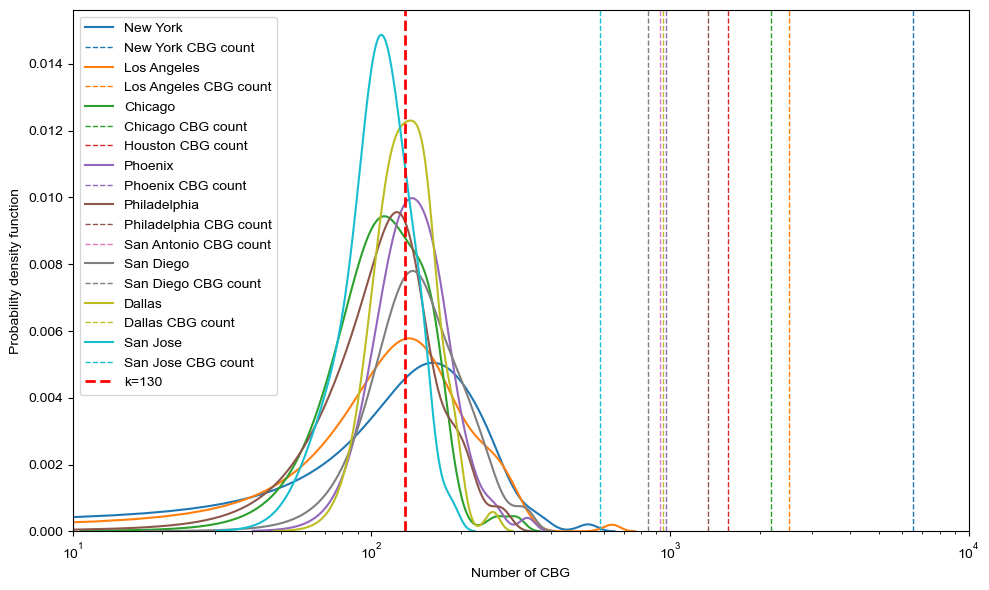

In [55]:
# Draw k distribution plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cities_short = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose']

cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))
delete_degrees = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250]


import matplotlib.pyplot as plt

df = pd.DataFrame(columns=cities)

for city in city_list:  
    if city == 4 or city == 7 :
        continue
    k_lst = []
    for year in years:
        for month in range(1,13):
                if os.path.exists(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2))):
                    tmp_ks = pd.read_csv(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2)))
                    # find the largest number in delete degrees that is smaller than the 2% cbg count of the city
                    if city != 1 and city != 7:
                        delete_degree = max([x for x in delete_degrees if x < 0.025*cbg_counts[city-1]])
                    else: 
                        delete_degree = max([x for x in delete_degrees if x < 0.025*cbg_counts[city-1]])
                    
                    k_lst.append(tmp_ks.loc[tmp_ks['delete_degree']==delete_degree, cities[city-1]].values[0])
    df[cities[city-1]] = k_lst

df.columns = cities_short

draw_hist(df, save=False)

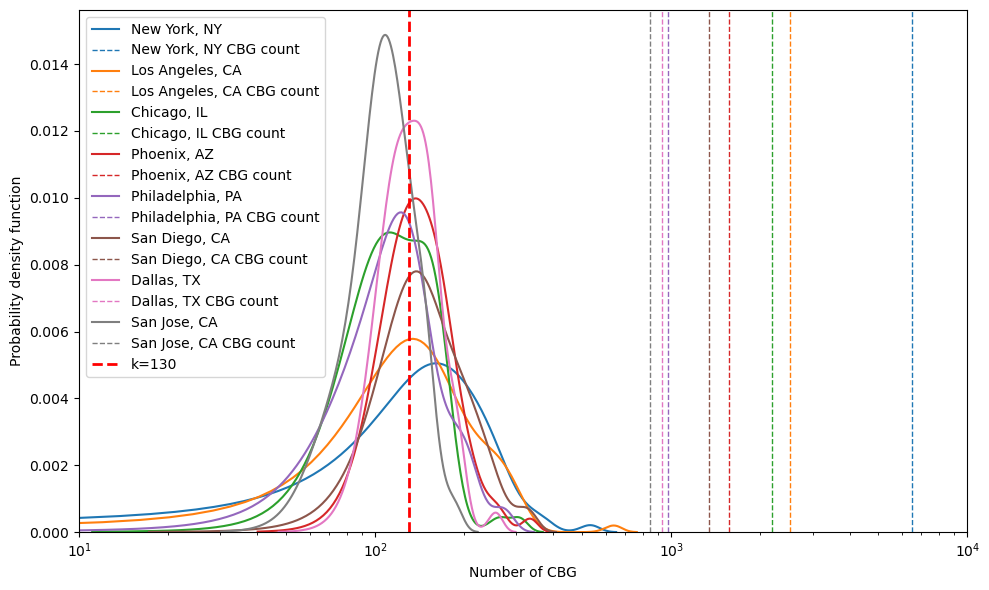

In [2]:
# Draw k distribution plots new
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cities_short = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose']

cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]

city_list = list(range(1,11))
df = pd.read_csv(r'..\results\k_select_US_2018-2021_filtered.csv', index_col=0)
#df.drop(columns=['year','month'], inplace=True)
#df.columns = cities_short

draw_hist(df, save=False)

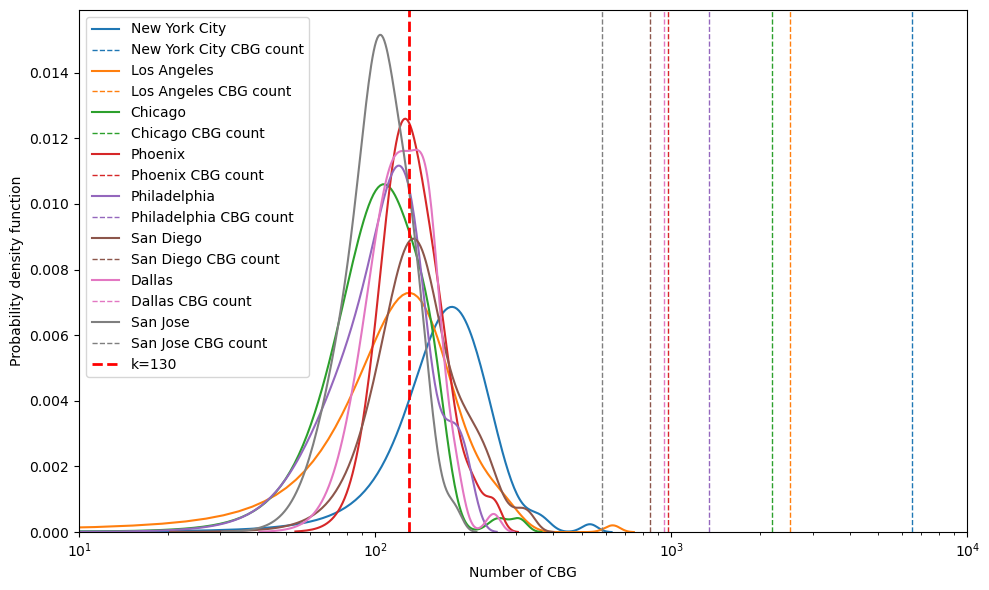

In [5]:
# Draw k distribution plots new
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cities_short = ['New York City', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose']

cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]

city_list = list(range(1,11))
df = pd.read_csv(r'.\k_select_US_newNY_5percent.csv', index_col=0)
df.drop(columns=['year','month'], inplace=True)
df.columns = cities_short

draw_hist(df, save=True)

## Show results of ks for American/Chinese cities.

In [1]:
def draw_k_box(df, cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583], year = "", save = False):
    fig, ax1 = plt.subplots()

    # 画箱线图
    green = (30/255, 134/255, 51/255)
    blue = (25/255,97/255,147/255)
    red = (201/255,	0/255,	42/255	)
    boxprops = dict(color=blue)
    medianprops = dict(color=green)
    whiskerprops = dict(color='Black')
    
    #df.boxplot(ax=ax1, boxprops=boxprops, medianprops=medianprops,whiskerprops=whiskerprops)
    df.boxplot(ax=ax1)
    ax1.set_yticks(np.arange(0, 1601, 200))
    ax1.set_ylabel('k Values')
    plt.xticks(rotation=45)
    
    # 创建第二个 y 轴
    ax2 = ax1.twinx()

    # 设置x轴为df的columns
    x = np.array(range(len(df.columns)))

    ax2.plot(x+1, cbg_counts, color='r', label='CBG Counts')
    ax2.set_ylabel('CBG Counts')

    # 添加图例
    ax2.legend(loc="upper right")

    plt.title("k's boxplots and CBG counts from 2018 to 2022".format(year) )
    plt.tight_layout()
    if year == "all":
        plt.savefig("k's boxplot and CBG counts from 2018 to 2022.png", dpi=300)

    else:
        plt.savefig("k's boxplot and CBG counts in year {}.png".format(year), dpi=300)
    plt.show()


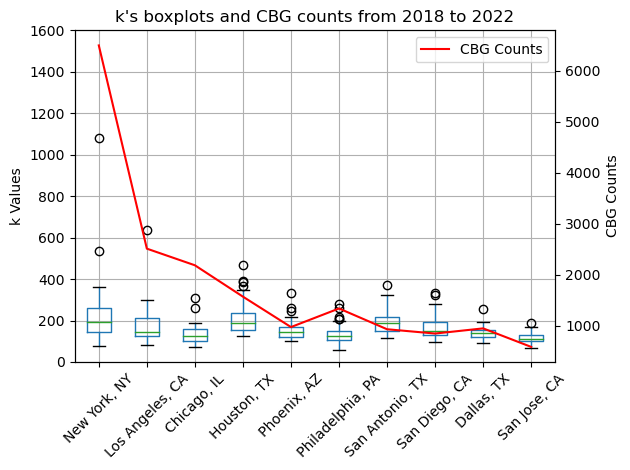

In [78]:
# New York without nodes whose degrees are below 130
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))
delete_degrees = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250]


import matplotlib.pyplot as plt

df = pd.DataFrame(columns=cities)

for city in city_list:
    k_lst = []
    for year in years:
        for month in range(1,13):
                if os.path.exists(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2))):
                    tmp_ks = pd.read_csv(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2)))
                    # find the largest number in delete degrees that is smaller than the 2% cbg count of the city
                    delete_degree = max([x for x in delete_degrees if x < 0.02*cbg_counts[city-1]])
                    k_lst.append(tmp_ks.loc[tmp_ks['delete_degree']==delete_degree, cities[city-1]].values[0])
    df[cities[city-1]] = k_lst

draw_k_box(df, year = "all", save = True)


In [ ]:
# Count how many cbgs to be excluded
delete_degree = max([x for x in delete_degrees if x < 0.025*cbg_counts[city-1]])


## Analysis for NewYork City(201805)

In [ ]:

delete_degrees = [ 100, 110, 120, 130, 140, 150, ]

import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']

flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_2018-05_1.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
#print(city, cities[city-1])
ks = minimum_flows_for_strongly_connectivity_extract_component_first(flow_matrix, delete_degrees)

# 绘制结果
plt.plot(delete_degrees, ks)
plt.xlabel('Delete Degree')
plt.ylabel('k (minimum flows for strong connectivity)')
plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
plt.grid(True)
plt.show()
plt.close()

In [ ]:

delete_degrees = [30, 50, 100, 150, 200, 250, 300, 350]

import matplotlib.pyplot as plt

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']

city = cities[0]
flow_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_2018-05_1.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
print(city)
results = []
for delete_degree in delete_degrees:
    # Convert the original flows to binary
    flows_binary = (flow_matrix > 0).astype(int)

    # Calculate the degrees based on the new definition
    degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

    # find the nodes whose degree are lower than 5
    nodes_to_remove = np.where(degrees_all < delete_degree)[0]
    print('Number of nodes to remove: ', len(nodes_to_remove))

    # Remove the ndoes from the matrix
    reduced_matrix = np.delete(flow_matrix, nodes_to_remove, axis=0)
    reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

    k=minimum_flows_for_strongly_connectivity(reduced_matrix)
    print(k)
    results.append(k)
print(results)
# 绘制结果# 绘制结果
plt.plot(delete_degrees, ks)
plt.xlabel('Delete Degree')
plt.ylabel('k (minimum flows for strong connectivity)')
plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
plt.grid(True)
plt.show()
plt.close()


In [ ]:
# preprocess the flow matrix

# 1. Load the .npy matrix
flow_matrix = np.load('/Users/zwy/Library/CloudStorage/Dropbox/urban cup/data/Mobility/cbg_visit_2018-05_1.npy')
delete_degree =110
# 2. Calculate the mean and standard error of the flows
mean_flow = np.mean(flow_matrix)
std_dev = np.std(flow_matrix)
standard_error = std_dev / np.sqrt(flow_matrix.size)

# 3. Set the small flows which are out of mean - 2*standard error to 0
flow_matrix_delete = np.copy(flow_matrix)
flow_matrix_delete[flow_matrix_delete < mean_flow - 2*standard_error] = 0

flows_binary = (flow_matrix > 0).astype(int)

# 4.Calculate the degrees based on the new definition
degrees_all = np.sum(np.logical_or(flow_matrix_delete, flow_matrix_delete.T), axis=1)

# 5. Delete units with binary degrees below 5
nodes_to_remove = np.where(degrees_all < delete_degree)[0]
print('Number of nodes to remove: ', len(nodes_to_remove))

# Remove the ndoes from the matrix
reduced_matrix = np.delete(flow_matrix, nodes_to_remove, axis=0)
reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

k=minimum_flows_for_strongly_connectivity(reduced_matrix)
print(k)

# 绘制结果# 绘制结果
plt.plot(delete_degrees, ks)
plt.xlabel('Delete Degree')
plt.ylabel('k (minimum flows for strong connectivity)')
plt.title('Variation of k with Delete Degree in {}'.format(cities[city-1]))
plt.grid(True)
plt.show()
plt.close()


101623.06337213871


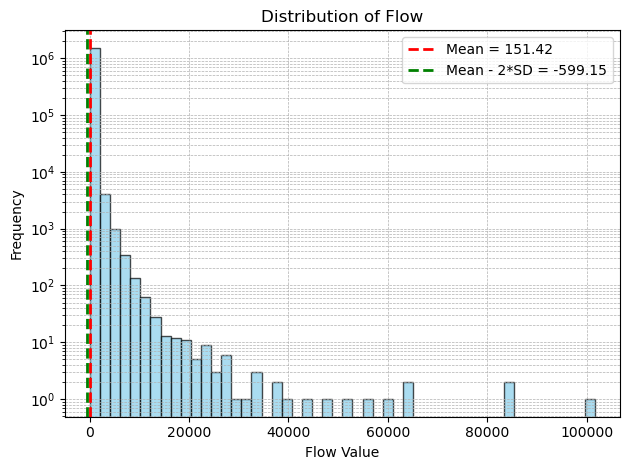

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the .npy matrix
matrix = np.load('/Users/zwy/Library/CloudStorage/Dropbox/urban cup/data/Mobility/cbg_visit_2018-06_1.npy')

# 2. Calculate the mean and standard error of the flows
mean_flow = np.mean(matrix)

std_dev = np.std(matrix)

#matrix[matrix > mean_flow + 2*std_dev] = mean_flow + 2*std_dev
print(matrix.max())

weights = np.delete(matrix.flatten(), np.where(matrix.flatten() == 0))
mean_flow = np.mean(weights)
std_dev = np.std(weights)

# 3. Plotting
plt.hist(weights, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_flow, color='r', linestyle='dashed', linewidth=2, label=f"Mean = {mean_flow:.2f}")
plt.axvline(mean_flow - 2*std_dev, color='g', linestyle='dashed', linewidth=2, label=f"Mean - 2*SD = {mean_flow - 2*std_dev:.2f}")

plt.title("Distribution of Flow")
plt.xlabel("Flow Value")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'CBG Degree Distribution')

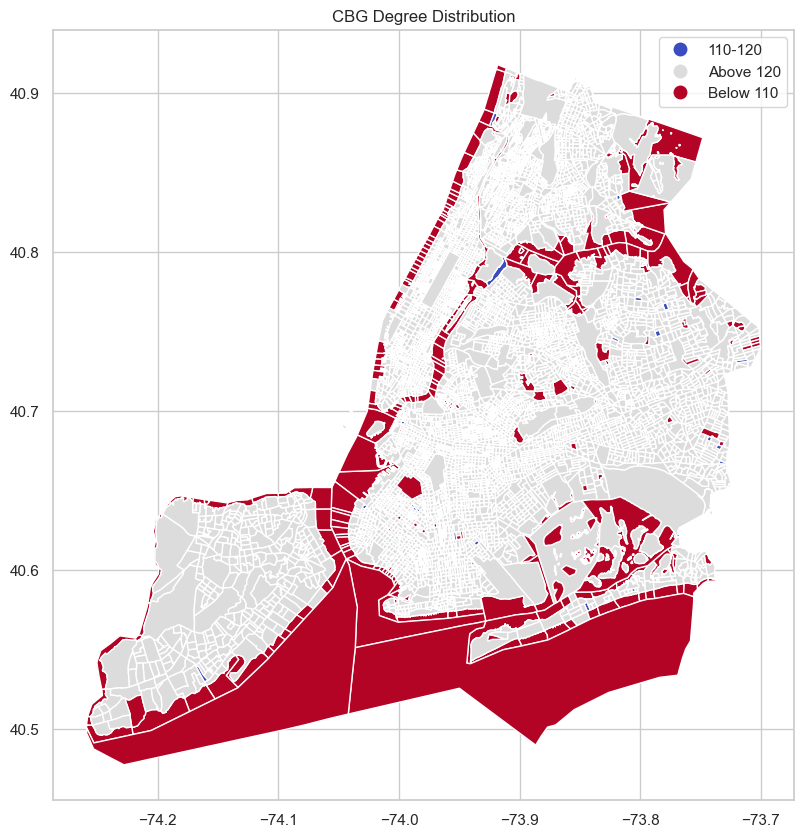

In [41]:
# Spacialize the mobility matrix of NewYork
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle

# Load the files
mobility_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_2018-05_1.npy')
with open(r"D:\Dropbox\urban cup\data\Mobility\id_dict_1.pkl", 'rb') as f:
    node_to_cbg = pickle.load(f)

gdf = gpd.read_file(r"D:\Dropbox\urban cup\arcgis project\cbgs\cbgs_of_cities\New_York_city.shp")

# Compute the degree for each node
flows_binary = (mobility_matrix > 0).astype(int)

# Calculate the degrees based on the new definition
degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

# Map node degree to CBG
cbg_to_degree = {node_to_cbg[node]: degree for node, degree in enumerate(degrees_all)}

# Classify CBGs based on degree
def classify_degree(degree):
    if degree > 120:
        return 'Above 120'
    elif 110 <= degree <= 120:
        return '110-120'
    else:
        return 'Below 110'

gdf['Degree_Class'] = gdf['CBG_Code'].map(lambda x: classify_degree(cbg_to_degree.get(x, 0)))

# Plot
ax = gdf.plot(column='Degree_Class', legend=True, cmap='coolwarm', figsize=(10, 10))
ax.set_title('CBG Degree Distribution')

gdf.to_file("NewYork_with_degree_distribution.shp")


C:\Users\zwy99\AppData\Local\Temp\ipykernel_26048\598877567.py:39: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("NewYork_with_degree_distribution.shp")


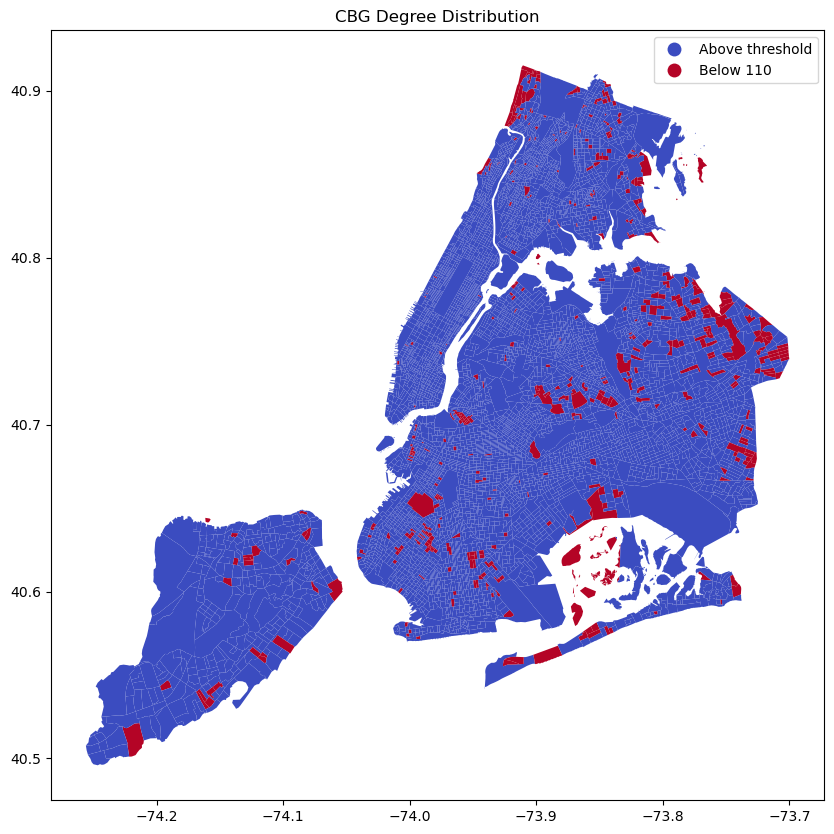

In [10]:
# Visualize the 2% percent of bottom degrees

import numpy as np
import pandas as pd
import geopandas as gpd
import pickle

# Load the files
mobility_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_2018-05_1.npy')
with open(r"D:\Dropbox\urban cup\data\Mobility\id_dict_1.pkl", 'rb') as f:
    node_to_cbg = pickle.load(f)

gdf = gpd.read_file(r"D:\Dropbox\urban cup\arcgis project\cbgs\cbgs_of_cities\NewYork\New_York_city.shp")
# Compute the degree for each node
flows_binary = (mobility_matrix > 0).astype(int)

# Calculate the degrees based on the new definition
degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

# Map node degree to CBG
cbg_to_degree = {node_to_cbg[node]: degree for node, degree in enumerate(degrees_all)}

# Classify CBGs based on degree

threshold = np.percentile(degrees_all, 10)

def classify_degree(degree):
    if degree > threshold:
        return 'Above threshold'
    else:
        return 'Below 110'

gdf['Degree_Class'] = gdf['CBG_Code'].map(lambda x: classify_degree(cbg_to_degree.get(x, 0)))

# Plot
ax = gdf.plot(column='Degree_Class', legend=True, cmap='coolwarm', figsize=(10, 10))
ax.set_title('CBG Degree Distribution')

gdf.to_file("NewYork_with_degree_distribution.shp")


In [ ]:
# Visualization for different ks
# Visualize the 2% percent of bottom degrees
# Cities except NY are not ready (shapefiles of single year are not available)

import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import networkx as nx

def get_k_subgraph(strongly_connected_G, k):

    new_graph = nx.DiGraph()
    for node in strongly_connected_G.nodes():
        edges = sorted(strongly_connected_G.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
        new_graph.add_edges_from(edges)

    scc_sub = list(nx.strongly_connected_components(new_graph))
    print("is strongly connected: ", nx.is_strongly_connected(new_graph))
    print("Number of classes: ", len(scc_sub))

    return scc_sub

# Load the files
mobility_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_2018-12_2.npy')
with open(r"D:\Dropbox\urban cup\data\Mobility\id_dict_2.pkl", 'rb') as f:
    node_to_cbg = pickle.load(f)

#gdf = gpd.read_file(r"D:\Dropbox\urban cup\arcgis project\cbgs\cbgs_of_cities\NewYork\New_York_city.shp")
gdf = gpd.read_file(r"D:\Dropbox\urban cup\arcgis project\cbgs\cbgs_of_cities\Los_Angeles_city.shp")


ks = [5, 10, 15, 20]
percentile = 2

"""reduced_nodes = not_in_cbgs
# Remove the nodes from the matrix
flow_matrix = np.delete(mobility_matrix, reduced_nodes, axis=0)
flow_matrix = np.delete(flow_matrix, reduced_nodes, axis=1)

original_indices = np.arange(mobility_matrix.shape[0])
preserved_indices = np.delete(original_indices, reduced_nodes)
node_to_cbg = {index: node_to_cbg[node] for index, node in enumerate(preserved_indices)}
"""
np.fill_diagonal(flow_matrix, 0)
numpy_array = flow_matrix
flows_binary = (numpy_array > 0).astype(int)
degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

percentile_threshold = np.percentile(degrees_all, percentile)
nodes_to_remove = np.where(degrees_all <= percentile_threshold)[0]

original_indices = np.arange(numpy_array.shape[0])
preserved_indices = np.delete(original_indices, nodes_to_remove)

reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)
reduced_G = nx.from_numpy_array(reduced_matrix, create_using=nx.DiGraph)

scc = list(nx.strongly_connected_components(reduced_G))
max_scc = max(scc, key=len)
preserved_indices = [index for index in preserved_indices if index in max_scc]
strongly_connected_G = reduced_G.subgraph(max(scc, key=len))

# 更新 node_to_cbg 映射
updated_node_to_cbg = {new_index: node_to_cbg[original_index] for new_index, original_index in enumerate(preserved_indices)}

for k in ks:    
    scc = get_k_subgraph(strongly_connected_G, k)

    classes = len(scc)
    print("k = ", k, "Number of classes: ", classes)
    cbg_to_class = {}
    for i, component in enumerate(scc):
        if len(component) <= 5:
            continue
        for node in component:
            cbg = updated_node_to_cbg.get(node)
            if cbg:
                cbg_to_class[cbg] = i

        
    gdf['Class'] = gdf['CBG_Code'].map(lambda x: cbg_to_class.get(x, -1))
    
    # Plot
    ax = gdf.plot(column='Class', legend=False, cmap='tab20', figsize=(10, 10))
    
    
    # 为每个簇创建图例项
    colormap = plt.cm.get_cmap('tab20', len(gdf['Class'].unique()))
    for i, cluster in enumerate(range(-1, len(gdf['Class'].unique())-1)):
        plt.scatter([], [], color=colormap(i), label=i)
        
    # 将图例放在图形外的右侧，根据类别数量调整列数
    plt.legend()

    plt.show()


## Calculation of network metrics

In [7]:
# Calculate the average distance and cluster coefficients under different k

import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import networkx as nx

def get_k_subgraph(strongly_connected_matrix, k):
    new_graph = nx.DiGraph()
    for node in strongly_connected_G.nodes():
        edges = sorted(strongly_connected_G.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
        new_graph.add_edges_from(edges)
        
    #print("is strongly connected: ", nx.is_strongly_connected(new_graph))

    return new_graph

ks = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700]
percentile = 2
city = 1
# Load the files
mobility_matrix = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_2018-12_{}.npy'.format(city))
if city == 1:
    reduced_nodes = not_in_cbgs
    # Remove the nodes from the matrix
    flow_matrix = np.delete(mobility_matrix, reduced_nodes, axis=0)
    flow_matrix = np.delete(flow_matrix, reduced_nodes, axis=1)

np.fill_diagonal(flow_matrix, 0)
numpy_array = flow_matrix
flows_binary = (numpy_array > 0).astype(int)
degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

percentile_threshold = np.percentile(degrees_all, percentile)
nodes_to_remove = np.where(degrees_all <= percentile_threshold)[0]

reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)
reduced_G = nx.from_numpy_array(reduced_matrix, create_using=nx.DiGraph)

scc = list(nx.strongly_connected_components(reduced_G))
strongly_connected_G = reduced_G.subgraph(max(scc, key=len))
strongly_connected_matrix = nx.to_numpy_array(strongly_connected_G, weight='weight')

# 初始化用于存储结果的数组
average_distances = []
average_cluster_coeffs = []

for k in ks:    
    graph = get_k_subgraph(strongly_connected_matrix, k)

    # 计算平均距离
    # 注意：nx.average_shortest_path_length 只适用于强连通图
    """try:
        avg_distance = nx.average_shortest_path_length(graph)
        average_distances.append(avg_distance)
    except nx.NetworkXError:
        # 如果图不是强连通的，我们无法计算平均距离
        print(f"Graph is not strongly connected for k={k}, cannot calculate average distance.")
        average_distances.append(np.nan)  # 使用np.nan作为无法计算时的占位符"""

    # 计算平均聚类系数
    avg_cluster_coeff = nx.average_clustering(graph.to_undirected())
    average_cluster_coeffs.append(avg_cluster_coeff)
    print("k = ", k, ", Average Clustering Coefficient: ", avg_cluster_coeff)

# 将结果转换为DataFrame以便查看和分析
results_df = pd.DataFrame({
    'k': ks,
    #'Average Distance': average_distances,
    'Average Clustering Coefficient': average_cluster_coeffs
})

print(results_df)

k =  5 , Average Clustering Coefficient:  0.3973834441722303
k =  10 , Average Clustering Coefficient:  0.36767951579381597
k =  15 , Average Clustering Coefficient:  0.33951613962543997
k =  20 , Average Clustering Coefficient:  0.3176304289086668
k =  30 , Average Clustering Coefficient:  0.2852844227960465
k =  40 , Average Clustering Coefficient:  0.26525170638052176
k =  50 , Average Clustering Coefficient:  0.251413158011899
k =  70 , Average Clustering Coefficient:  0.23409835578403274
k =  90 , Average Clustering Coefficient:  0.2257397651380982
k =  110 , Average Clustering Coefficient:  0.2229608701498561
k =  130 , Average Clustering Coefficient:  0.22371472700296494
k =  150 , Average Clustering Coefficient:  0.22657600914264467
k =  200 , Average Clustering Coefficient:  0.2372317028966329


KeyboardInterrupt: 

## Temporal Sequence

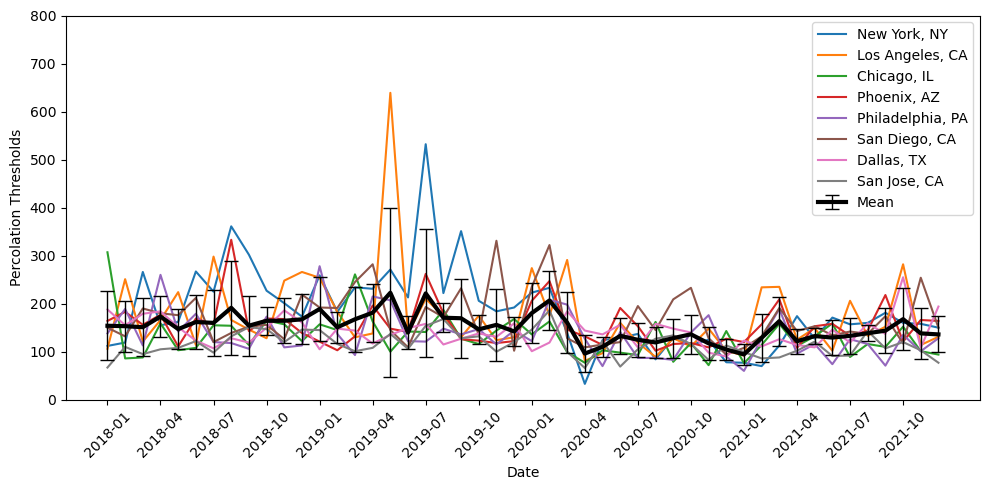

    New York, NY  Los Angeles, CA  Chicago, IL  Phoenix, AZ  Philadelphia, PA  \
0            112              106          307          164               138   
1            119              251           86          183               189   
2            266              121           88          156               113   
3            155              166          159          177               260   
4            162              224          103          111               142   
5            267              114          108          169               179   
6            225              298          155          157               120   
7            361              166          154          333               118   
8            302              146          114          143               106   
9            227              128          165          169               173   
10           201              248          157          168               109   
11           173            

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))
delete_degrees = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250]
month_year_labels = []

import matplotlib.pyplot as plt

df = pd.DataFrame(columns=cities)

for city in city_list:
    k_lst = []
    if city == 4 or city == 7:
        continue
    for year in years:
        for month in range(1,13):
                if os.path.exists(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2))):
                    tmp_ks = pd.read_csv(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2)))
                    # find the largest number in delete degrees that is smaller than the 2% cbg count of the city
                    if city != 1 and city != 7:
                        delete_degree = max([x for x in delete_degrees if x < 0.02*cbg_counts[city-1]])
                    else: 
                        delete_degree = max([x for x in delete_degrees if x < 0.025*cbg_counts[city-1]])
                    k_lst.append(tmp_ks.loc[tmp_ks['delete_degree']==delete_degree, cities[city-1]].values[0])
                    if city == city_list[-1]:
                        month_year_labels.append("{year_}-{month_}".format(month_ = str(month).zfill(2), year_ = year))
    df[cities[city-1]] = k_lst

df.drop(['Houston, TX','San Antonio, TX'], axis=1, inplace=True)
df["mean"] = df.mean(axis=1)

# 计算标准偏差
# using the columes except the mean column
df["std"] = df.loc[:, df.columns[:-1]].std(axis=1)

# 创建一个图形
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

# 对每个城市进行绘制
for city in cities:
    if city == 'Houston, TX' or city =='San Antonio, TX': continue
    ax.plot(df.loc[:,city].to_list(), label=city)


# 设置标题、轴标签等
#ax.set_title('K across time')
ax.set_xlabel('Date')
ax.set_ylabel('Percolation Thresholds')

# 调整x轴标签以展示年-月
num_months = len(df.index.unique())
# 删除旧的平均值线
#ax.plot(df.loc[:,"mean"].to_list(), label="mean", color="black", linewidth=3)

# 使用errorbar绘制平均值线及其误差
ax.errorbar(range(num_months), df["mean"].to_list(), yerr=df["std"].to_list(),label="Mean", color="black", linewidth=3,elinewidth=1, capsize=5, capthick=1, )

ax.set_xticks(list(range(num_months))[::3])
ax.set_xticklabels(month_year_labels[::3], rotation=45, )

ax.legend()
ax.set_ylim(0, 800)
plt.tight_layout()
plt.savefig("k_across_time_with_error_bar.png", dpi=300)
plt.show()


print(df)

#df.to_csv("k_across_time.csv")



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))
delete_degrees = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250]
month_year_labels = []

import matplotlib.pyplot as plt

df = pd.read_csv(r".\k_select_US_newNY_5percent.csv")

for city in city_list:
    k_lst = []
    if city == 4 or city == 7:
        continue
    for year in years:
        for month in range(1,13):
                if os.path.exists(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2))):
                    tmp_ks = pd.read_csv(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2)))
                    # find the largest number in delete degrees that is smaller than the 2% cbg count of the city
                    if city != 1 and city != 7:
                        delete_degree = max([x for x in delete_degrees if x < 0.02*cbg_counts[city-1]])
                    else: 
                        delete_degree = max([x for x in delete_degrees if x < 0.025*cbg_counts[city-1]])
                    k_lst.append(tmp_ks.loc[tmp_ks['delete_degree']==delete_degree, cities[city-1]].values[0])
                    if city == city_list[-1]:
                        month_year_labels.append("{year_}-{month_}".format(month_ = str(month).zfill(2), year_ = year))
    df[cities[city-1]] = k_lst

df.drop(['Houston, TX','San Antonio, TX'], axis=1, inplace=True)
df["mean"] = df.mean(axis=1)

# 计算标准偏差
# using the columes except the mean column
df["std"] = df.loc[:, df.columns[:-1]].std(axis=1)

# 创建一个图形
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

# 对每个城市进行绘制
for city in cities:
    if city == 'Houston, TX' or city =='San Antonio, TX': continue
    ax.plot(df.loc[:,city].to_list(), label=city)


# 设置标题、轴标签等
#ax.set_title('K across time')
ax.set_xlabel('Date')
ax.set_ylabel('K')

# 调整x轴标签以展示年-月
num_months = len(df.index.unique())
# 删除旧的平均值线
#ax.plot(df.loc[:,"mean"].to_list(), label="mean", color="black", linewidth=3)

# 使用errorbar绘制平均值线及其误差
ax.errorbar(range(num_months), df["mean"].to_list(), yerr=df["std"].to_list(),label="Mean", color="black", linewidth=3,elinewidth=1, capsize=5, capthick=1, )

ax.set_xticks(list(range(num_months))[::3])
ax.set_xticklabels(month_year_labels[::3], rotation=45, )

ax.legend()
ax.set_ylim(0, 800)
plt.tight_layout()
plt.savefig("k_across_time_with_error_bar.png", dpi=300)
plt.show()


print(df)

df.to_csv("k_across_time.csv")



In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Load the data
data = pd.read_csv('.\k_across_time.csv')
mean_values = data.mean(axis=1)

# Split the data into pre-COVID and post-COVID segments based on April 2020 index
april_2020_index = 28  # 0-based index for April 2020
pre_covid_data = mean_values[:april_2020_index]
post_covid_data = mean_values[april_2020_index:]

# Function to run linear regression and report results
def run_regression_and_report(data_segment, segment_name):
    X = np.array(range(len(data_segment))).reshape(-1, 1)
    X_const = sm.add_constant(X)
    model = sm.OLS(data_segment, X_const).fit()
    coef = model.params[1]
    std_error = model.bse[1]
    p_value = model.pvalues[1]
    
    print(f"Results for {segment_name}:")
    print(f"Coefficient: {coef:.4f}")
    print(f"Standard Error: {std_error:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print("--------------------------------------------------")

# Run regression and report results for both segments
run_regression_and_report(pre_covid_data, "Pre-COVID-19")
run_regression_and_report(post_covid_data, "Post-COVID-19")


Results for Pre-COVID-19:
Coefficient: 0.1346
Standard Error: 0.5498
P-Value: 0.8085
--------------------------------------------------
Results for Post-COVID-19:
Coefficient: 1.3631
Standard Error: 0.5162
P-Value: 0.0166
--------------------------------------------------


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[154.    153.125 151.    173.25  147.125 161.75  160.    191.375 154.125
 164.375 164.375 167.375 188.875 150.75  167.5   181.25  222.75  140.
 221.375 170.75  169.625 146.5   155.875 142.125 180.375 206.625 160.625]
Results for Pre-COVID-19:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.446
Date:                Sat, 28 Oct 2023   Prob (F-statistic):              0.240
Time:                        10:59:40   Log-Likelihood:                -120.48
No. Observations:                  27   AIC:                             245.0
Df Residuals:                      25   BIC:                             247.5
Df Model:                           1    

d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.c

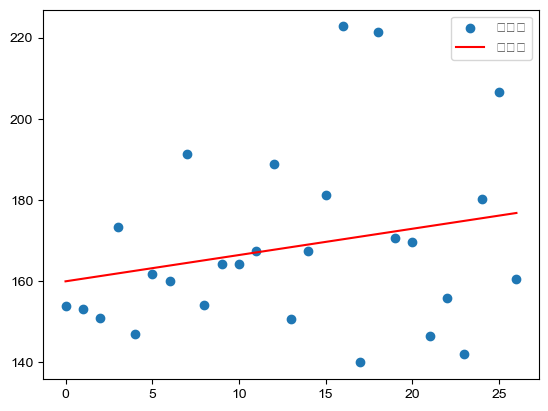

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 96.125 110.125 133.    124.75  119.25  128.25  136.25  117.375 104.625
  94.375 128.875 163.625 121.75  132.5   129.375 133.    138.5   143.75
 167.75  138.125 136.   ]
Results for Post-COVID-19:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     9.607
Date:                Sat, 28 Oct 2023   Prob (F-statistic):            0.00590
Time:                        10:59:40   Log-Likelihood:                -86.135
No. Observations:                  21   AIC:                             176.3
Df Residuals:                      19   BIC:                             178.4
Df Model:                           1                                         
Covariance Type:          

d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Software\anaconda\envs\zwy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.c

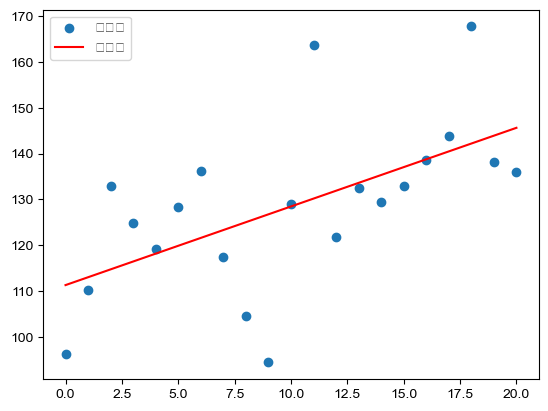

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = pd.read_csv('.\k_across_time.csv')
mean_values = data.loc[:, "mean"]


# Split the data into pre-COVID and post-COVID segments based on April 2020 index
april_2020_index = 27  # 0-based index for April 2020
pre_covid_data = mean_values[:april_2020_index]
post_covid_data = mean_values[april_2020_index:]

def run_lr(mean_values, segment_name):
    x = np.array(range(len(mean_values)))
    print(x)
    y = mean_values.to_numpy()
    print(y)
    x = sm.add_constant(x) # 若模型中有截距，必须有这一步
    model = sm.OLS(y, x).fit() # 构建最小二乘模型并拟合
    print(f"Results for {segment_name}:")
    print(model.summary()) # 输出回归结果

    # 画图
    # 这两行代码在画图时添加中文必须用
    print(x)
    print(x.shape, y.shape)
    predicts = model.predict() # 模型的预测值
    plt.scatter(x[:,-1], y, label='实际值') # 散点图
    plt.plot(x[:,-1], predicts, color = 'red', label='预测值')
    plt.legend() # 显示图例，即每条线对应 label 中的内容
    plt.show() # 显示图形

# Run regression and report results for both segments
run_lr(pre_covid_data, "Pre-COVID-19")
run_lr(post_covid_data, "Post-COVID-19")

## Saturation 

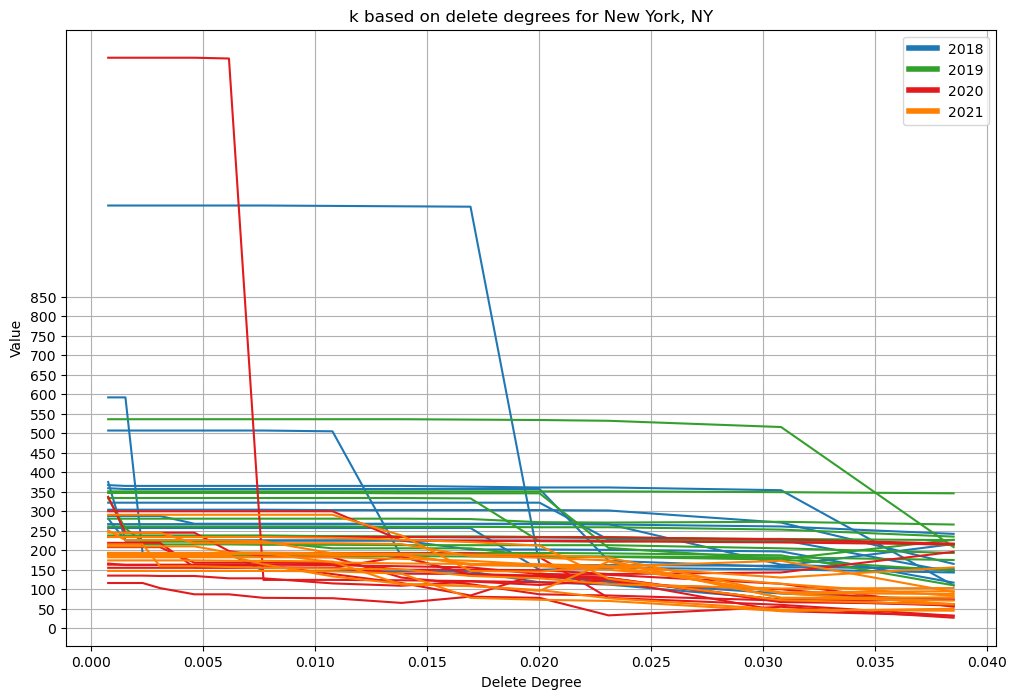

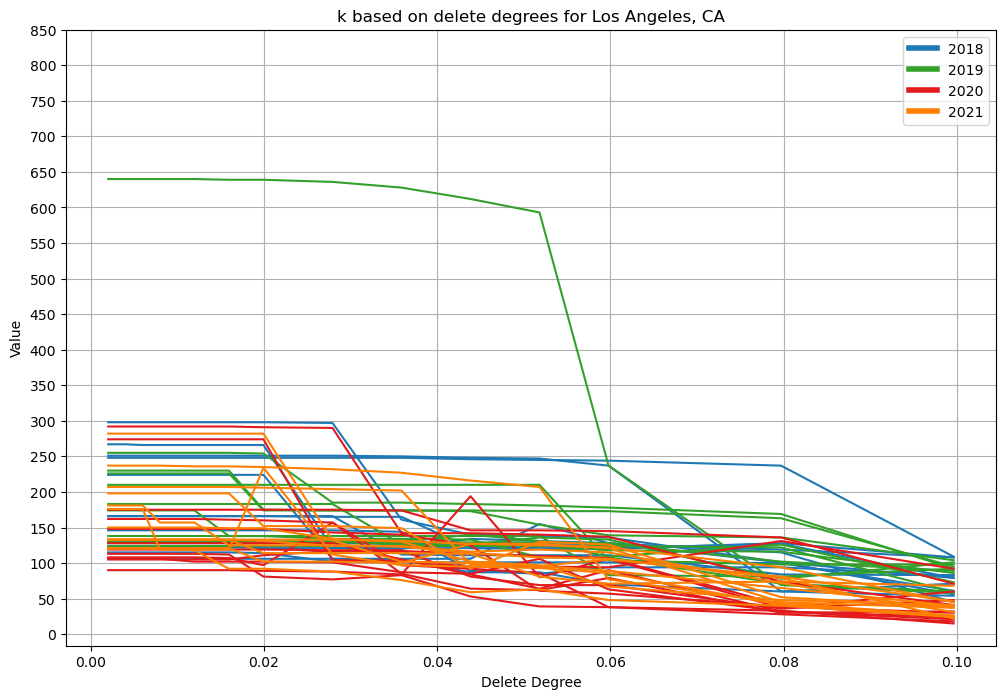

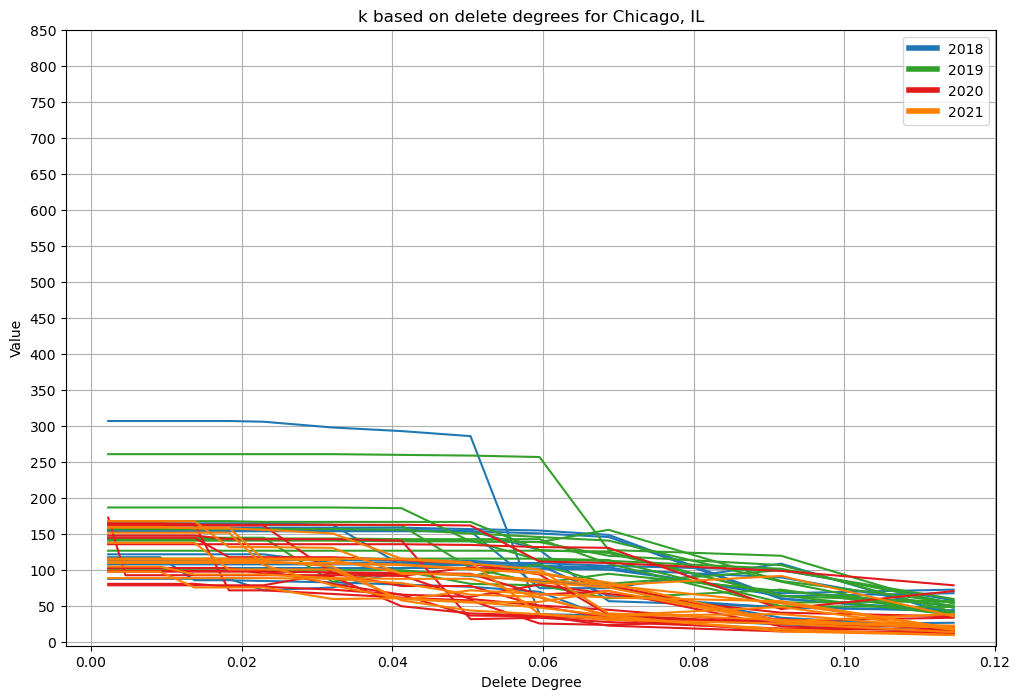

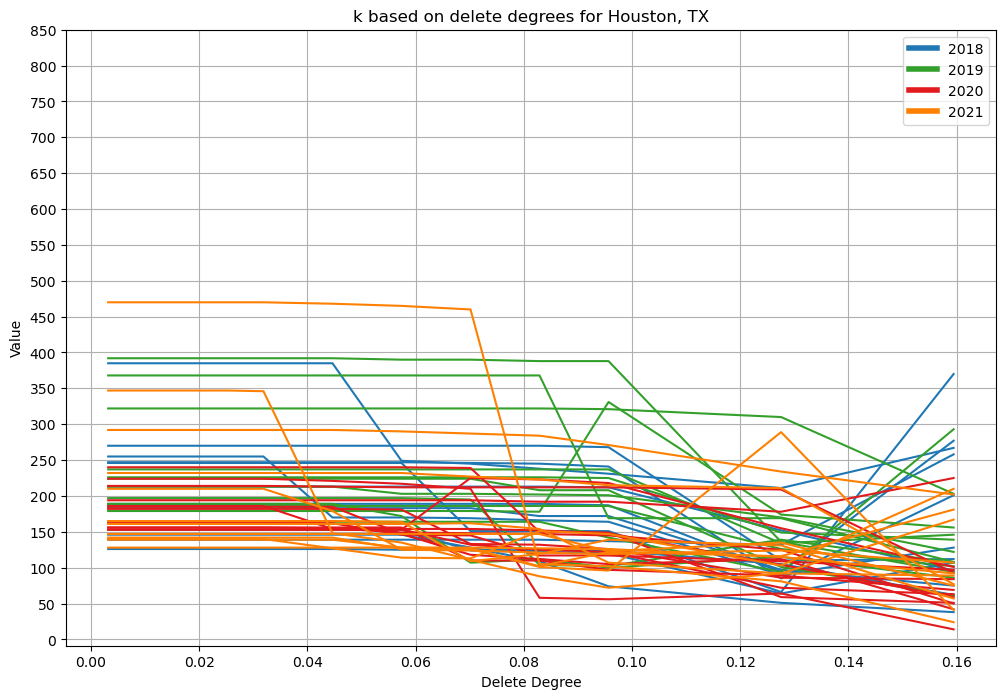

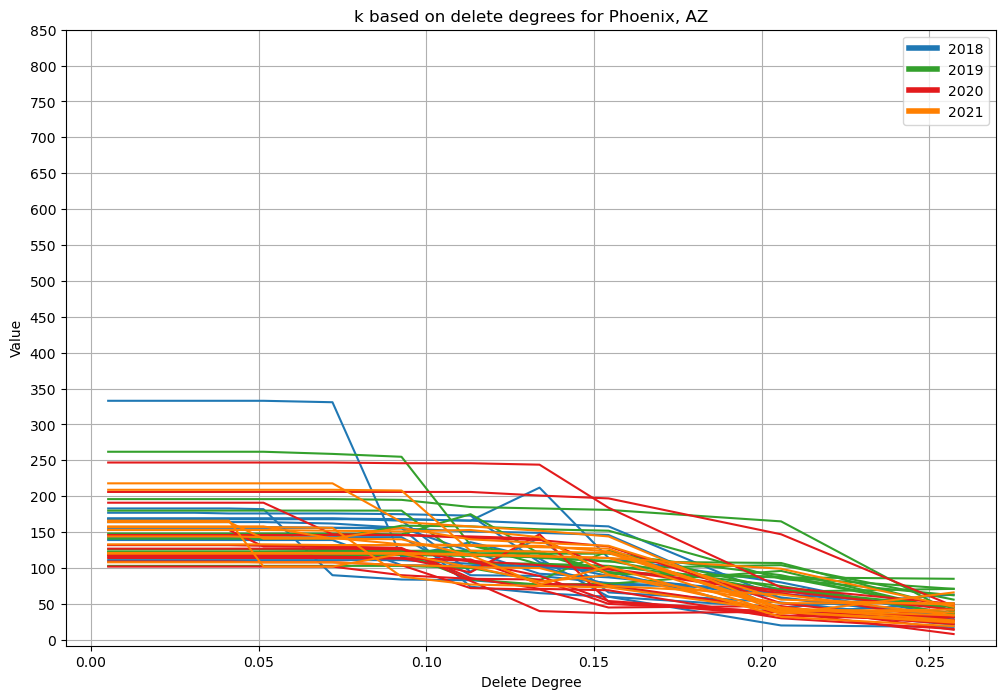

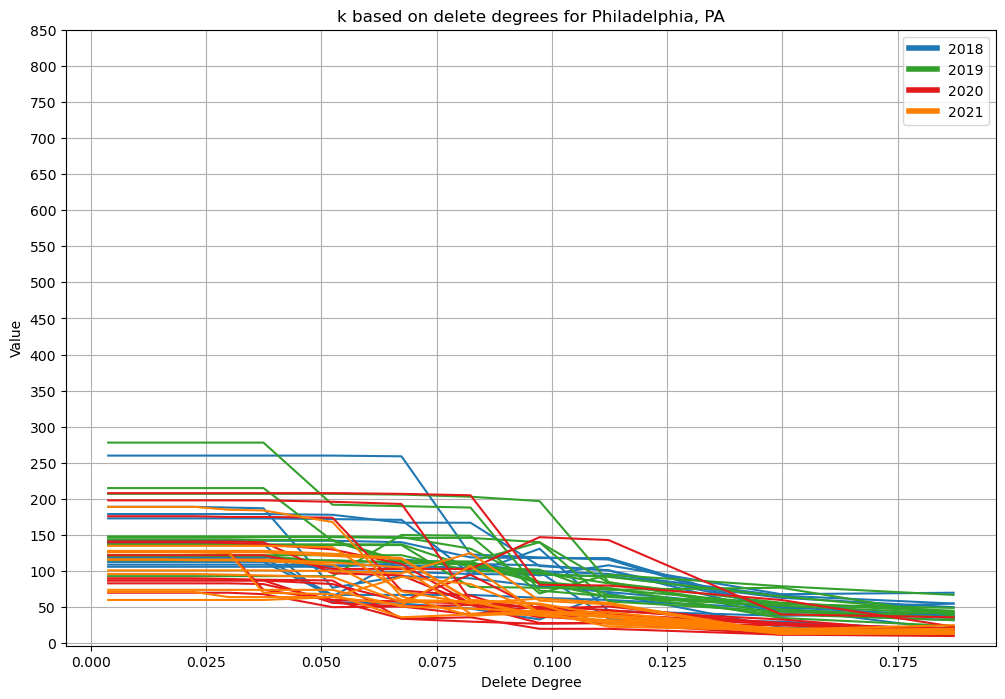

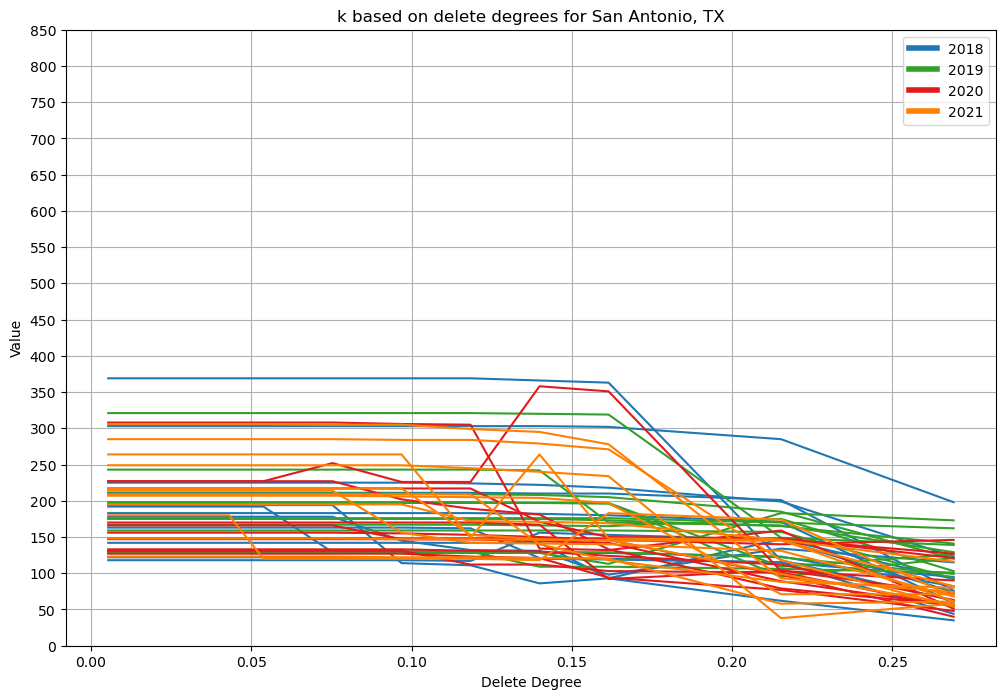

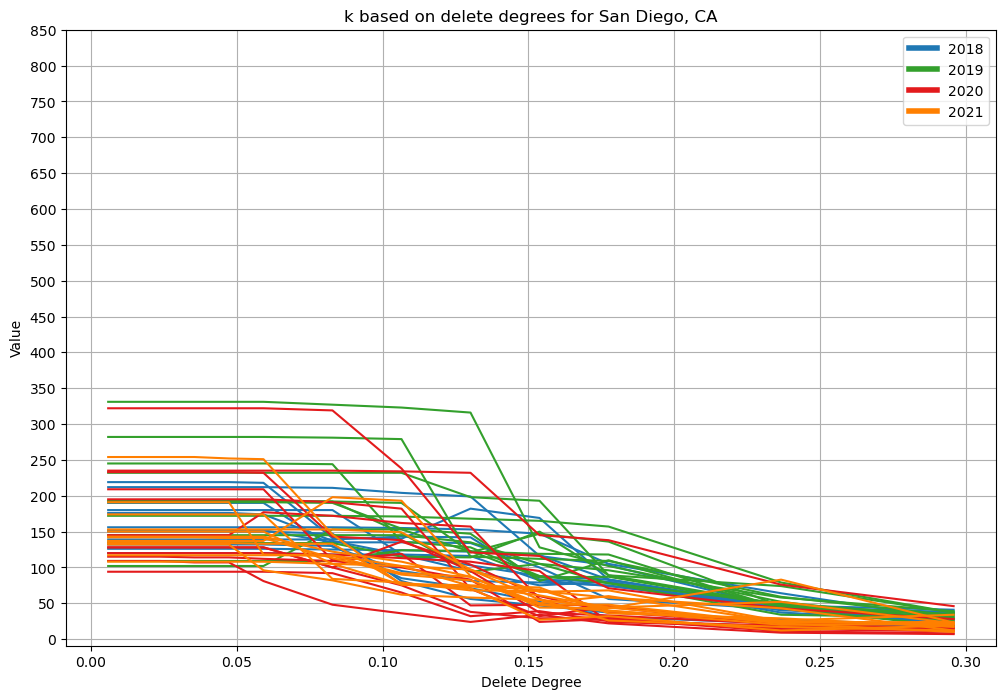

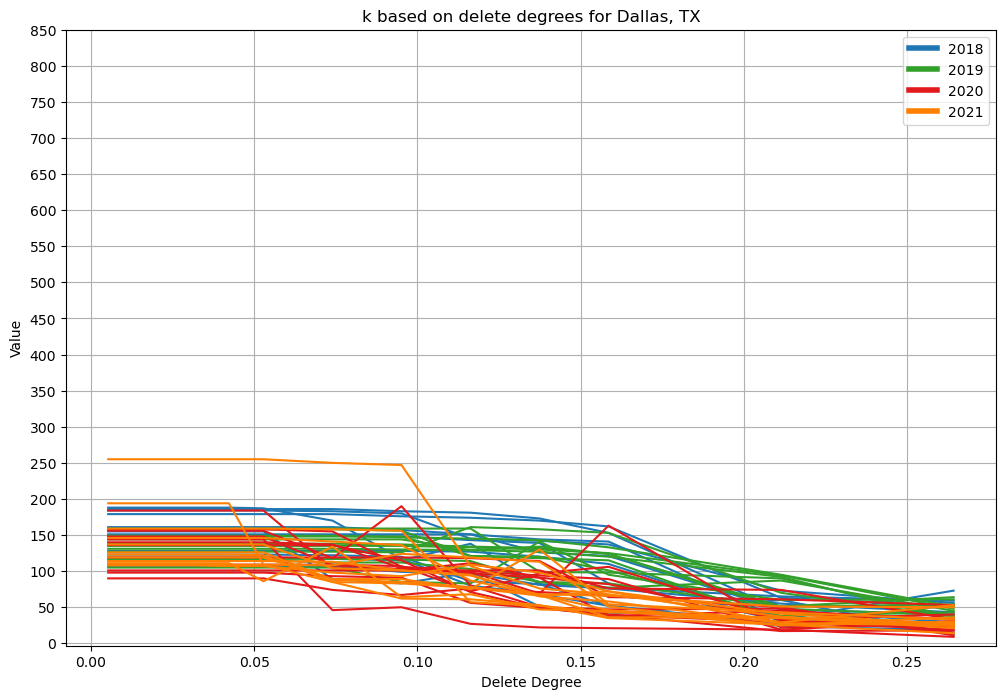

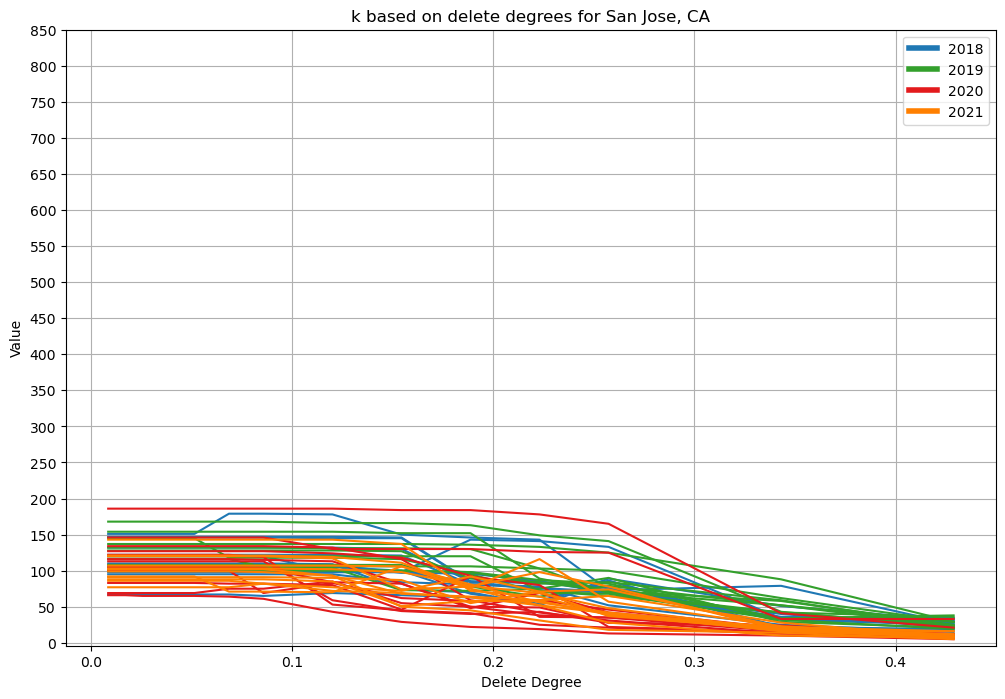

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))

# Set a color palette
palette = sns.color_palette("Paired")

for city in city_list:
    plt.figure(figsize=(12, 8))
    # Denser grid
    plt.gca().yaxis.grid(True, which='both')
    plt.gca().xaxis.grid(True, which='both')
    for year in years:
        for month in range(1,13):
            tmp_ks = pd.read_csv(r'..\results\k-select results\k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2)))
            plt.plot(tmp_ks["delete_degree"]/cbg_counts[city-1], tmp_ks[cities[city-1]], label=month, color = palette[year%2018 *2 +1])
            #print(city, cities[city-1])
    
    custom_lines = [
        Line2D([0], [0], color=palette[1], lw=4),
        Line2D([0], [0], color=palette[3], lw=4),
        Line2D([0], [0], color=palette[5], lw=4),
        Line2D([0], [0], color=palette[7], lw=4),
        ]
    
    plt.yticks(np.arange(0, 900, 50))
    plt.title("k based on delete degrees for {city}".format(city = cities[city-1]))
    plt.xlabel("Delete Degree")
    plt.ylabel("Value")
    
    plt.legend(custom_lines, ['2018', '2019', '2020','2021'])
    plt.show()
    plt.close()

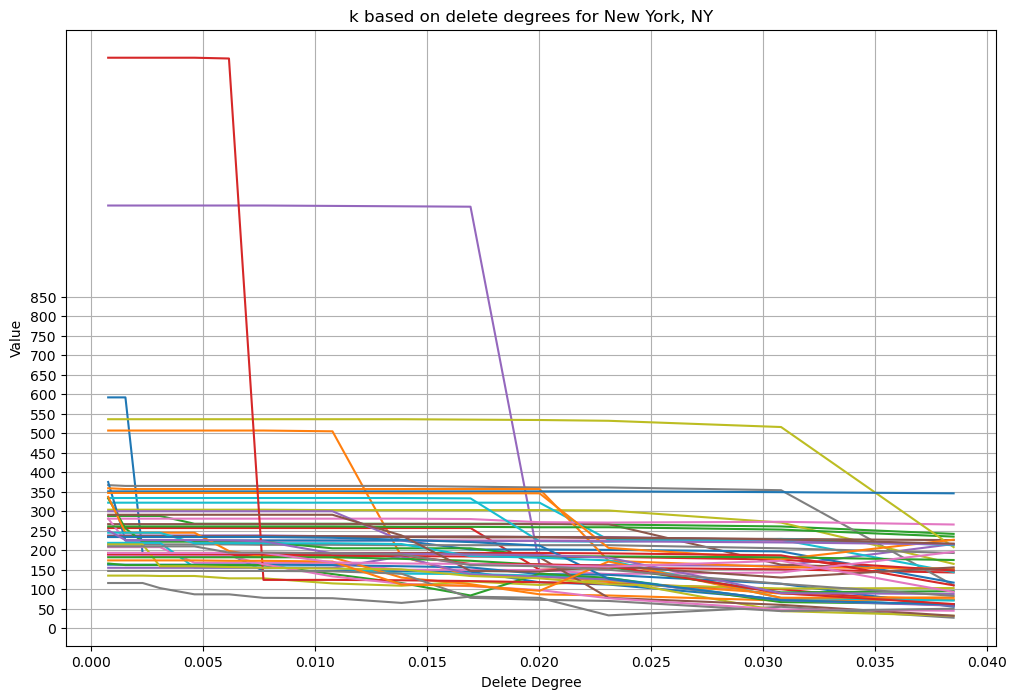

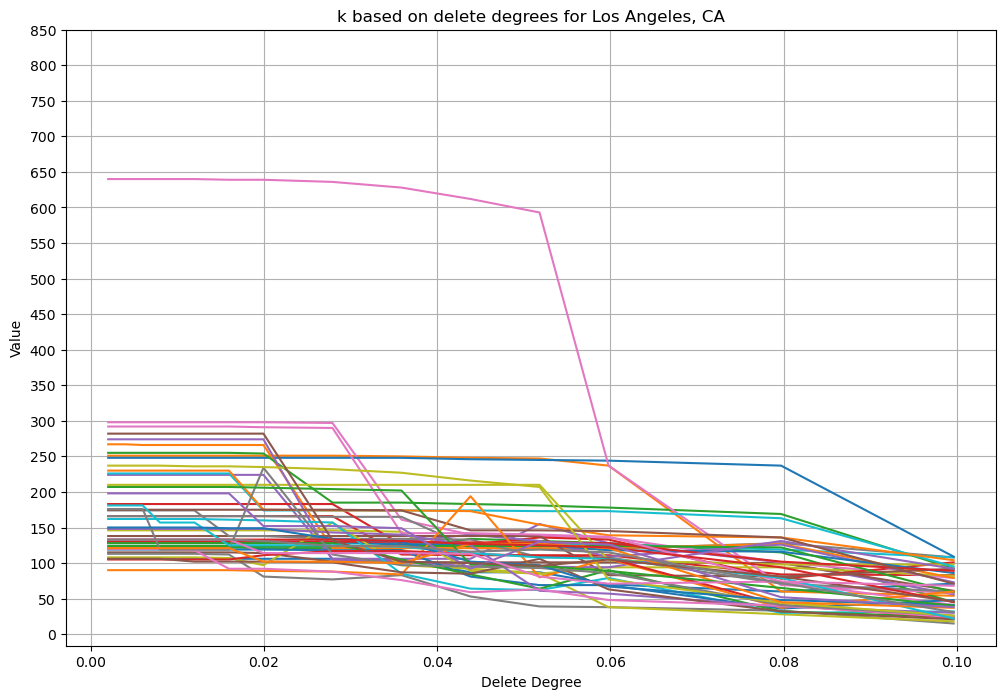

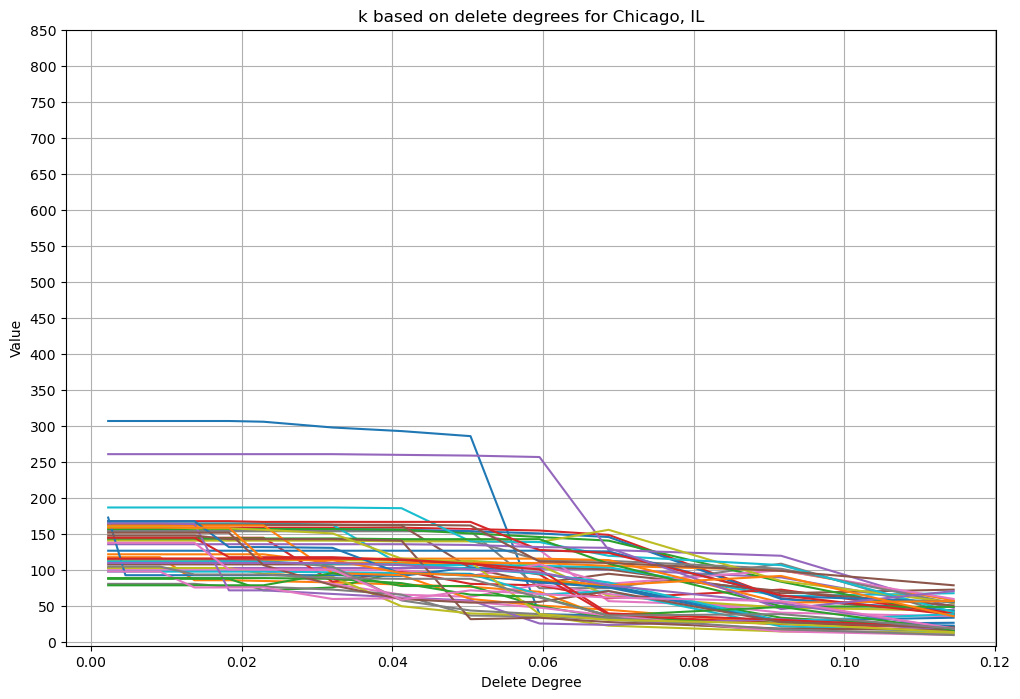

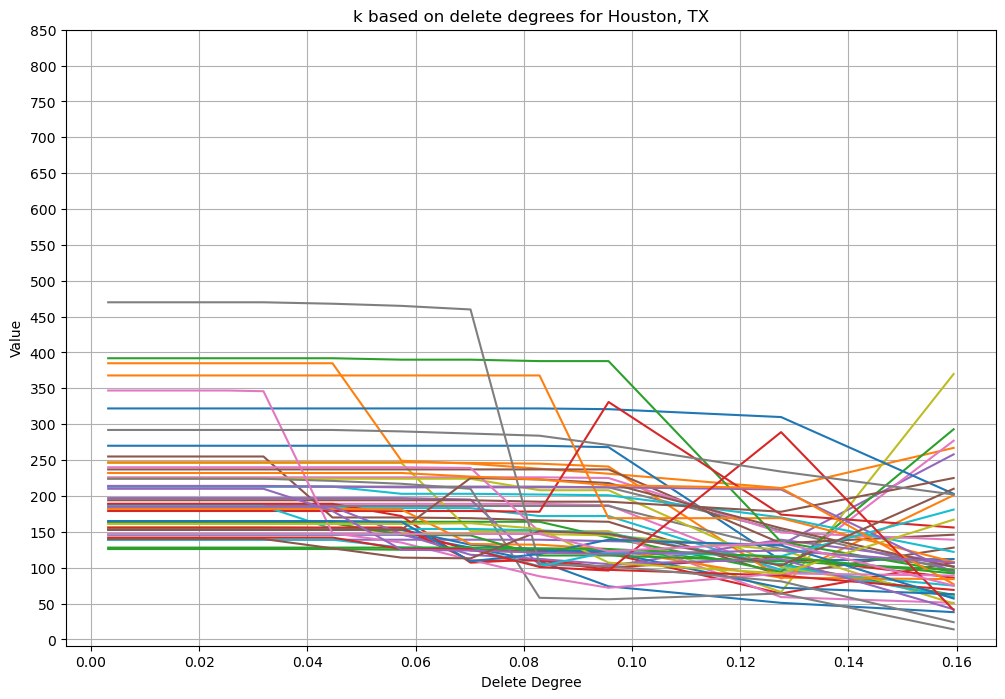

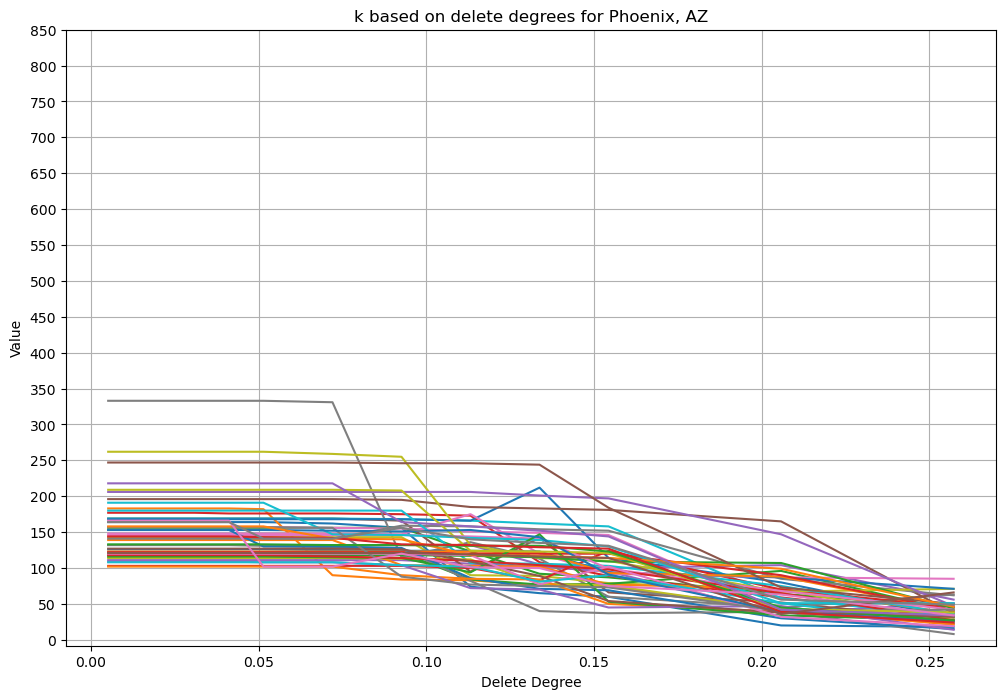

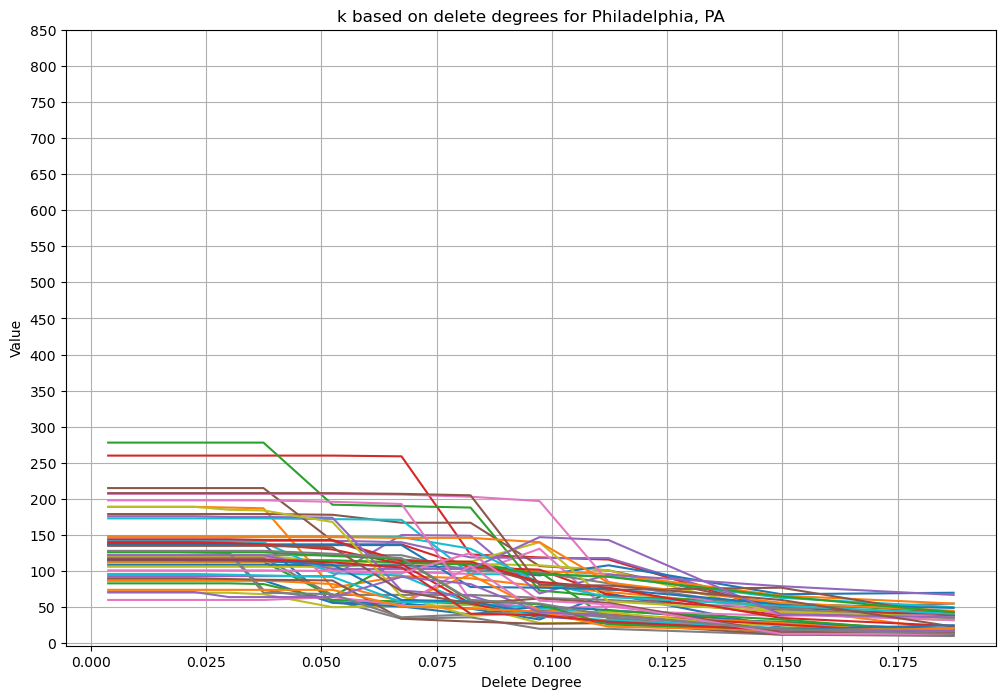

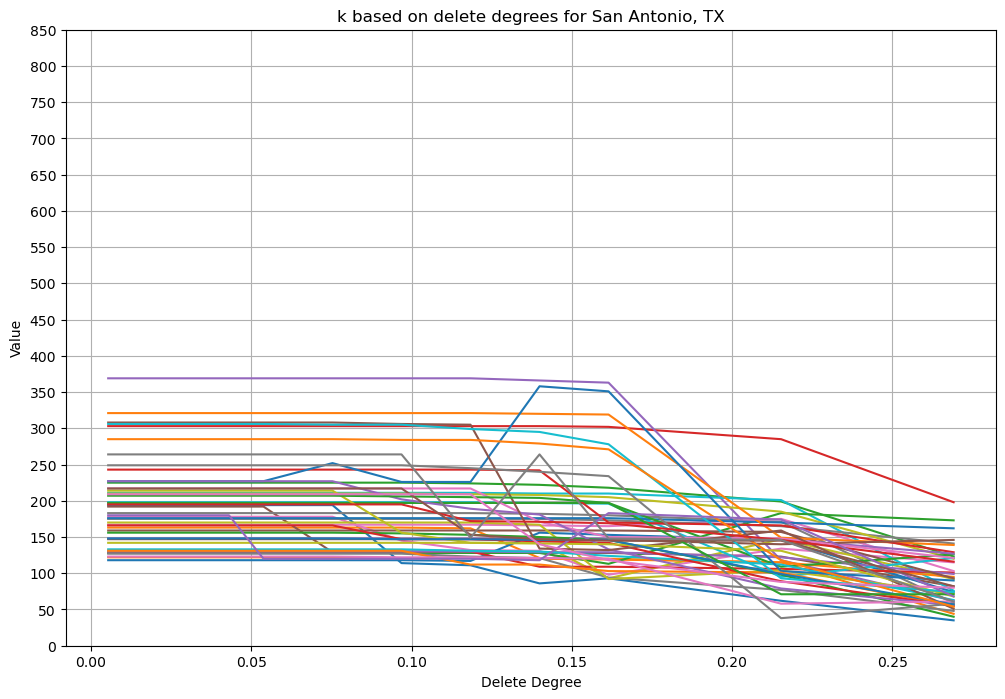

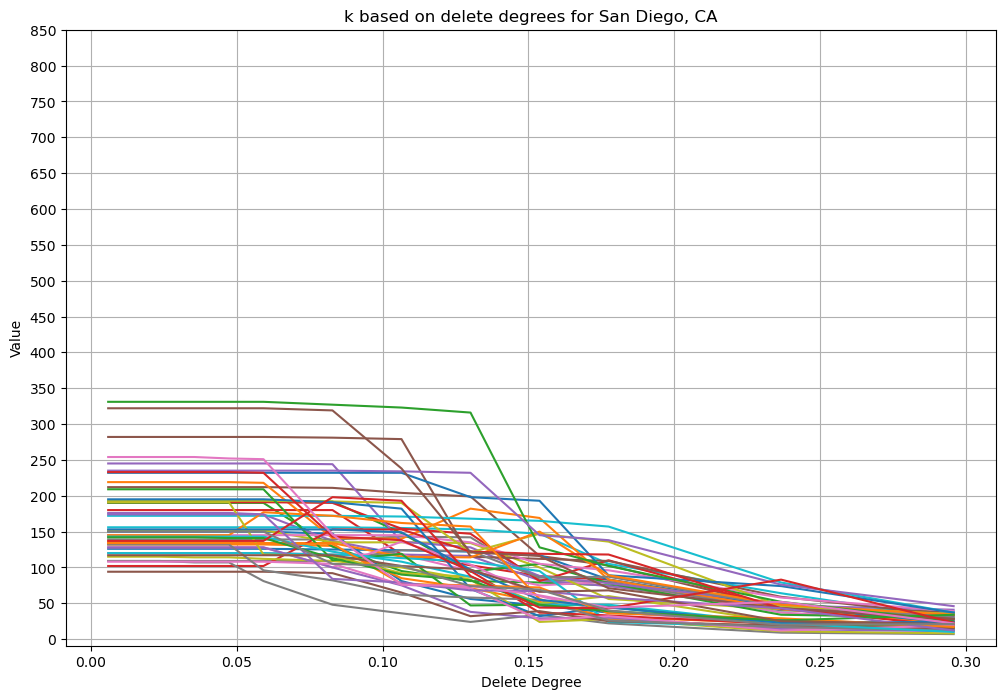

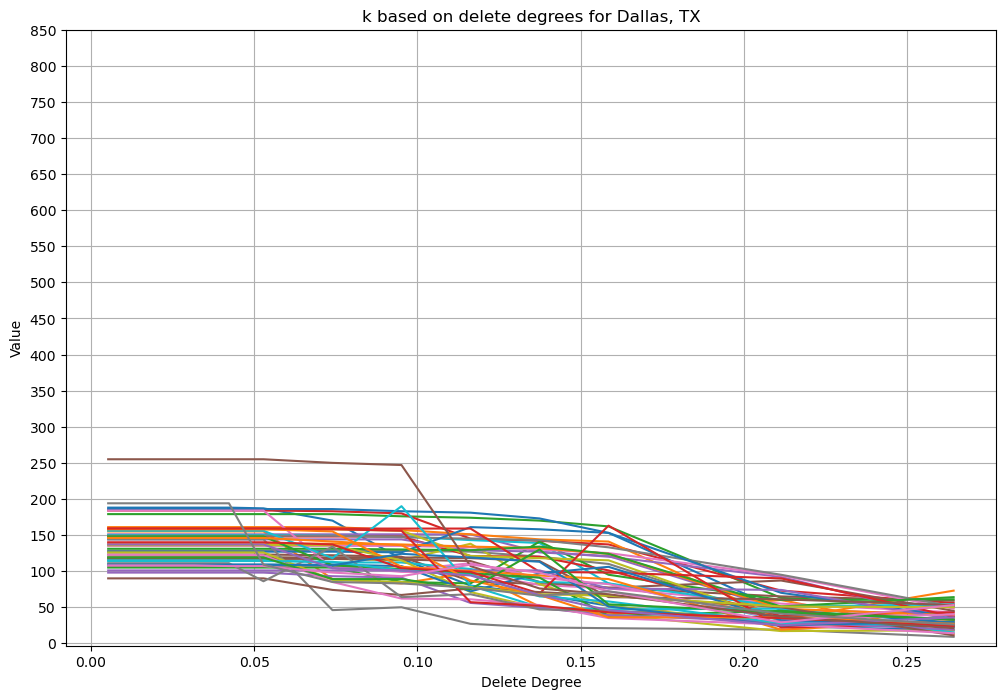

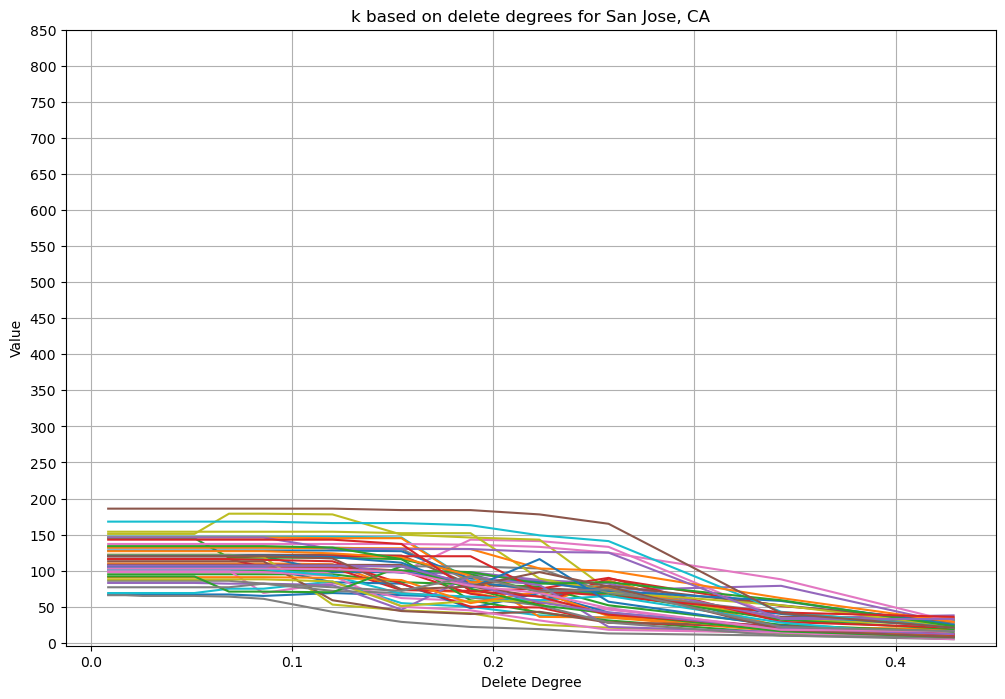

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))
for city in city_list:
    plt.figure(figsize=(12, 8))
    # Denser grid
    plt.gca().yaxis.grid(True, which='both')
    plt.gca().xaxis.grid(True, which='both')
    for year in years:
        for month in range(1,13):
            tmp_ks = pd.read_csv(r'K-select results/k_select_US_{year_}-{month_}_delete_first.csv'.format(year_ = year, month_ = str(month).zfill(2)))
            plt.plot(tmp_ks["delete_degree"]/cbg_counts[city-1], tmp_ks[cities[city-1]], label=month)
            #print(city, cities[city-1])
        
    plt.yticks(np.arange(0, 900, 50))
    plt.title("k based on delete degrees for {city}".format(city = cities[city-1]))
    plt.xlabel("Delete Degree")
    plt.ylabel("Value")
    #plt.legend(loc='best')
    plt.show()
    plt.close()

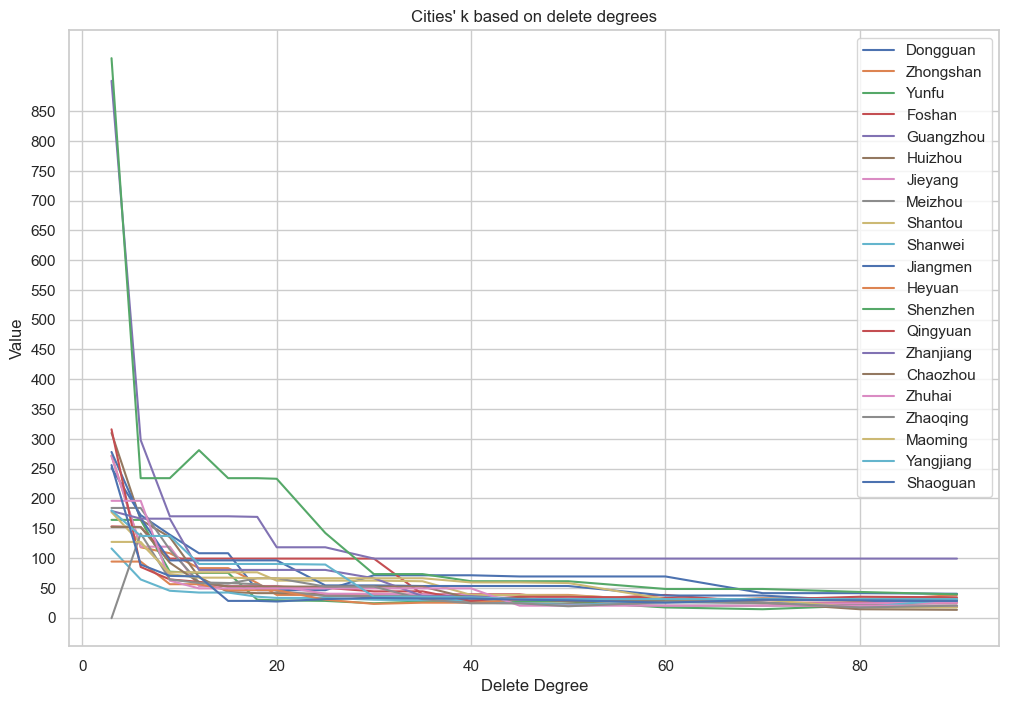

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV file
data = pd.read_csv(r"k_select_Guangdong.csv")

# Set "delete_degree" as index
data.set_index('delete_degree', inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
# Seaborn settings
sns.set(style="whitegrid")
palette = sns.color_palette("Paired")

# Plotting
plt.figure(figsize=(12, 8))
for idx, column in enumerate(data.columns):
    plt.plot(data.index, data[column], label=column)


# Denser grid
plt.gca().yaxis.grid(True, which='both')
plt.gca().xaxis.grid(True, which='both')

plt.yticks(np.arange(0, 900, 50))
plt.title("Cities' k based on delete degrees")
plt.xlabel("Delete Degree")
plt.ylabel("Value")
plt.legend(loc='best')
plt.savefig('k_select_Guangdong.png', dpi=300)
plt.show()



In [17]:
results

[545,
 545,
 545,
 545,
 545,
 545,
 545,
 545,
 401,
 401,
 401,
 401,
 196,
 196,
 125,
 125,
 125,
 125,
 125,
 125,
 125,
 125,
 125,
 125,
 124]

In [ ]:

# Calculate the minimum k for strongly connectivity for each city-month and record them.
k_table = pd.DataFrame(columns=['year','month'])
for i in range(1, 11):
    k_table[i] = -100

k_table.set_index(['year', 'month'], inplace=True)

for year in range(2019, 2023):
    for month in range(1, 13):
        for city in range(1, 11):
            if os.path.exists(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city)) == False:
                print("No data for {year_}-{month_}_{city_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city))
                continue
            flow_matrix = np.load(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
            k = minimum_flows_for_strongly_connectivity(flow_matrix)
            #print("{year_}-{month_}_{city_}:{k_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city,k_=k))
            k_table.loc[(year,month),city] = k
k_table.to_csv("all_k.csv")

In [ ]:
# Plot the map of the the share of the top-k flows in the total flows of each CBG

# Load your numpy array and node to CBG mapping
flow_matrix = np.load('path_to_your_file.npy')
with open('id_dict_{city_id}.pkl', 'rb') as f:
    id_dict = pickle.load(f)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Basic_Geographic_Statistics_CBG.csv')

# Convert the WKT boundary strings into shapely objects
df['Boundary'] = df['Boundary'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='Boundary')

# Calculate the share of the top k flows from each CBG of the total flow from each CBG
flow_sum = flow_matrix.sum(axis=1)
flow_top_k_sum = np.sort(flow_matrix, axis=1)[:, -k:].sum(axis=1)
flow_share = flow_top_k_sum / flow_sum

# Create a mapping from CBG code to flow share
flow_share_dict = {id_dict[i]: flow_share[i] for i in range(flow_matrix.shape[0])}

# Map the flow share values to the CBGs in the GeoDataFrame
gdf['Flow Share'] = gdf['CBG Code'].map(flow_share_dict)

# Plot the map, coloring the CBGs based on the flow share
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(column='Flow Share', ax=ax, legend=True, cmap='coolwarm')

# Set the title
plt.title('Flow Share by CBG')

# Save the plot
plt.savefig('flow_share_map.png', dpi=300)


In [ ]:
# Calculating entropy of outflows for each CBG
import numpy as np
from scipy.stats import entropy

# Normalize the flow matrix so that each row sums to 1
flow_matrix_normalized = flow_matrix / flow_matrix.sum(axis=1, keepdims=True)

# Compute the entropy of each row of the flow matrix
# Note that scipy's entropy function computes the natural logarithm, so to get base 2 logarithms, we set the base parameter to 2
entropies = entropy(flow_matrix_normalized.T, base=2)

# Create a mapping from CBG code to entropy
entropy_dict = {id_dict[i]: entropies[i] for i in range(flow_matrix.shape[0])}

# Map the entropy values to the CBGs in the GeoDataFrame
gdf['Entropy'] = gdf['CBG Code'].map(entropy_dict)

# Plot the map, coloring the CBGs based on the entropy
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(column='Entropy', ax=ax, legend=True, cmap='viridis')

# Set the title
plt.title('Entropy by CBG')

# Save the plot
plt.savefig('entropy_map.png', dpi=300)



In [ ]:
# Calculate total flows of one year for each cities.
# And then calculate the minimum flow for strongly connectivity.

def cal_total_flow(year, city):
    """_summary_

    Args:
        year (_type_): _description_
        city (_type_): _description_

    Returns:
        _type_: _description_
    """    
    # Define the file name pattern and the months
    filename_pattern = r"data\Mobility\cbg_visit_{year}-{month}_{city}.npy"

    months = range(1,13)
    # Initialize an empty array to hold the total flow
    total_flow = None

    # Load each file and add it to the total flow
    for month in months:
        file_name = filename_pattern.format(month = str(month).zfill(2), year = year, city = city)
        if os.path.exists(file_name):
            monthly_flow = np.load(file_name)
            if total_flow is None:
                total_flow = monthly_flow
            else:
                total_flow += monthly_flow
        else:
            print("no file of {}".format(file_name))
    return total_flow
# Now `total_flow` holds the sum of all the monthly flows
k_table = pd.DataFrame(columns=['year'])
for i in range(1, 11):
    k_table[i] = -100

k_table.set_index(['year'], inplace=True)


for year in range(2018, 2023):
    for city in range(1, 11):
        flow_matrix = cal_total_flow(year, city)
        k = minimum_flows_for_strongly_connectivity(flow_matrix)
        #print("{year_}-{month_}_{city_}:{k_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city,k_=k))
        k_table.loc[year,city] = k
k_table.to_csv("all_k_yearly.csv")

/var/folders/lx/48nrsg4n38b36nwmsqwzzqxh0000gn/T/ipykernel_31613/1741706520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_year.drop(['year', 'month'], axis=1, inplace=True)
/var/folders/lx/48nrsg4n38b36nwmsqwzzqxh0000gn/T/ipykernel_31613/1741706520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_year.drop(['year', 'month'], axis=1, inplace=True)
/var/folders/lx/48nrsg4n38b36nwmsqwzzqxh0000gn/T/ipykernel_31613/1741706520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

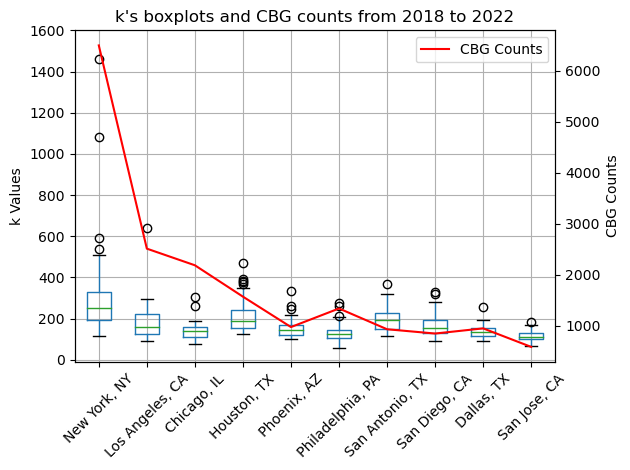

In [9]:
import matplotlib.pyplot as plt

df = pd.read_csv(r"all_k.csv")
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']

df.columns = ['year', 'month']+cities
for year in range(2018,2022):
#year = 2020
    # 选择2018年的数据
    df_single_year = df[df["year"] == year]
    df_single_year.drop(['year', 'month'], axis=1, inplace=True)
    #draw_k_box(df_single_year, year = year, save = True)

df.drop(['year', 'month'], axis=1, inplace=True)
draw_k_box(df, year = "all", save = True)

In [31]:
import matplotlib.pyplot as plt

# 将 'year' 和 'month' 设为索引
df.set_index(['year', 'month'], inplace=True)

# 获取年份列表
years = df.index.get_level_values('year').unique()
city_list = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
# 创建一个图形
fig, ax = plt.subplots(1)

# 为每个年份绘制一条折线
for ax, year in zip(axs, years):
    # 获取该年份的数据
    df_year = df.xs(year, level='year')
    
    # 对每个城市进行绘制
    for city in city_list:
        ax.plot(df_year.index, df_year[city], label=city)

    # 设置标题、轴标签等
    ax.set_title(f'Data for the year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Data')
    ax.legend()

plt.tight_layout()
plt.show()


KeyError: "None of ['year', 'month'] are in the columns"

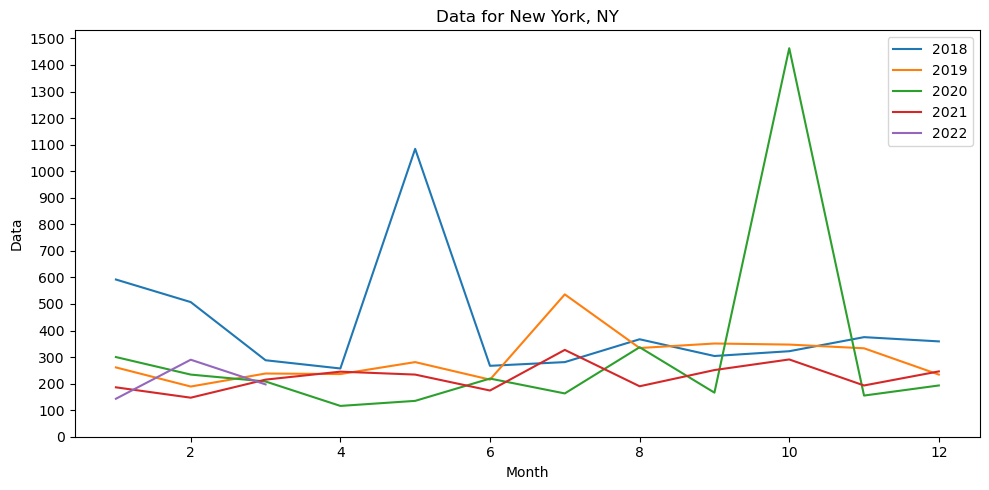

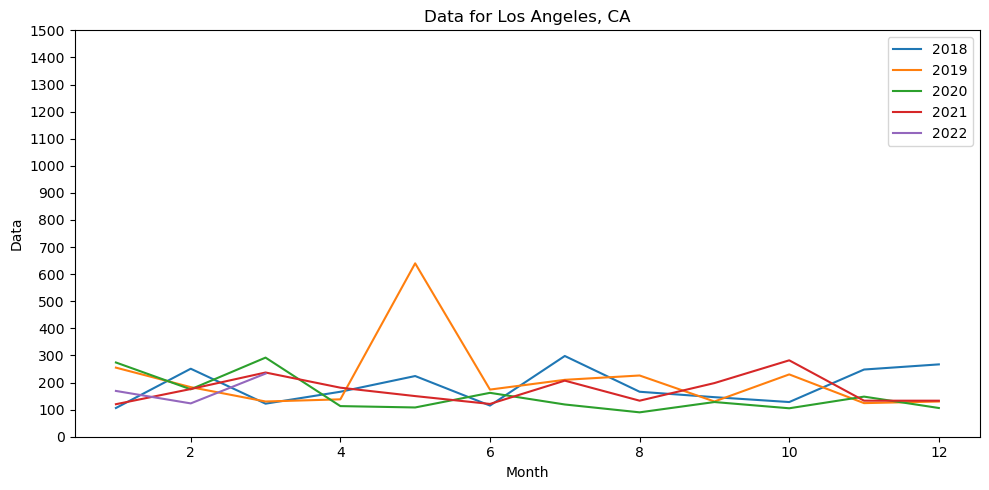

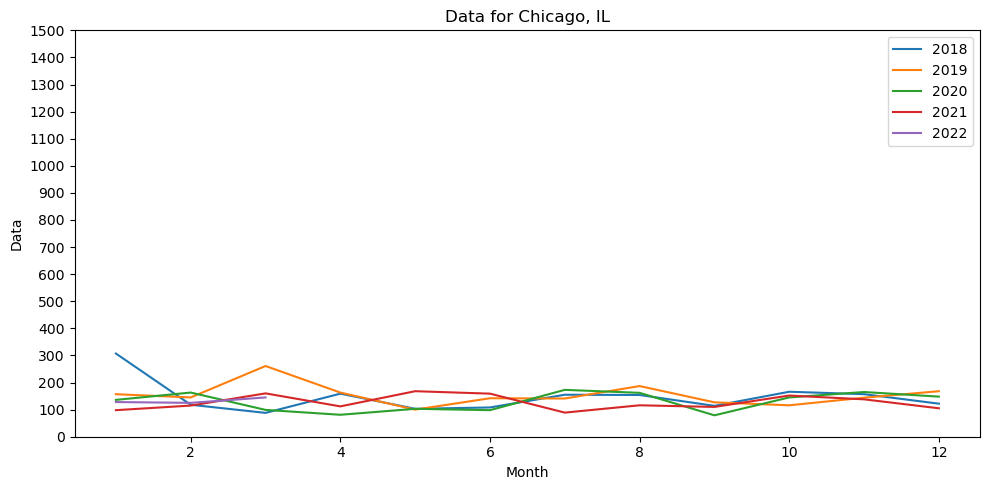

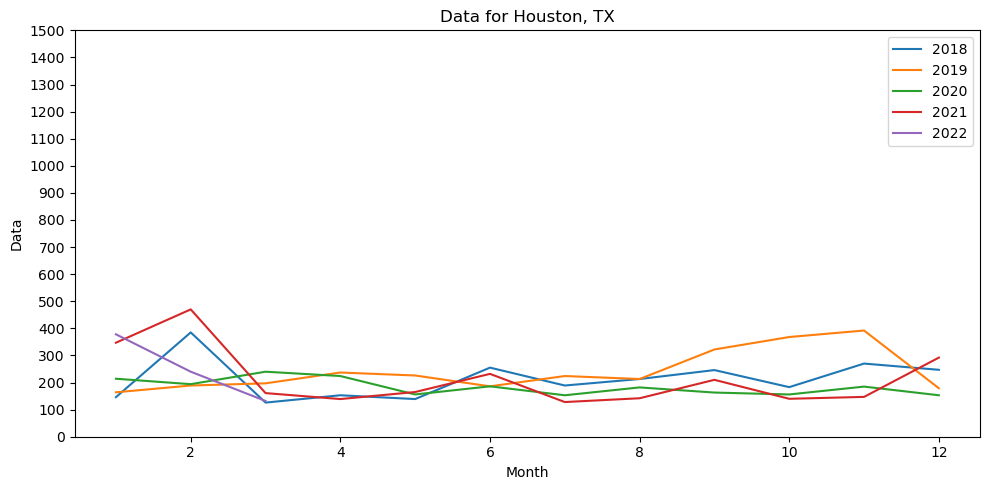

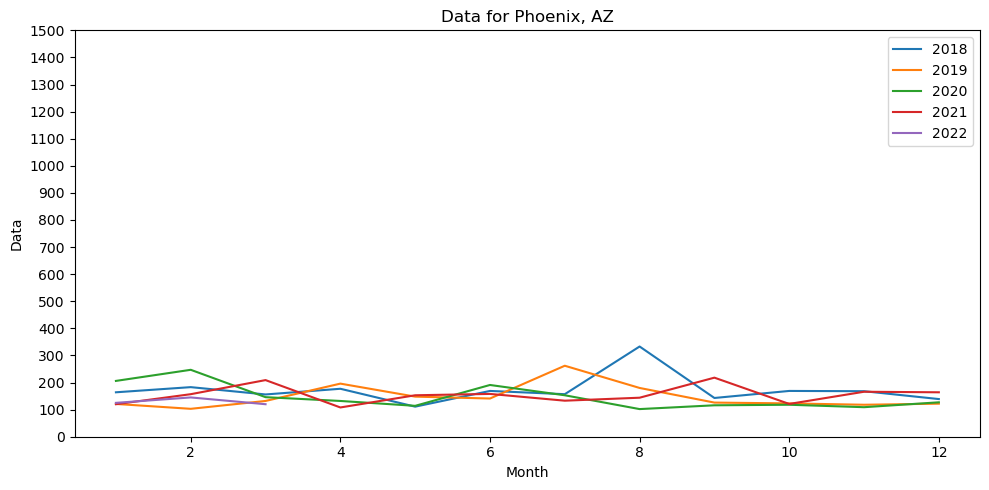

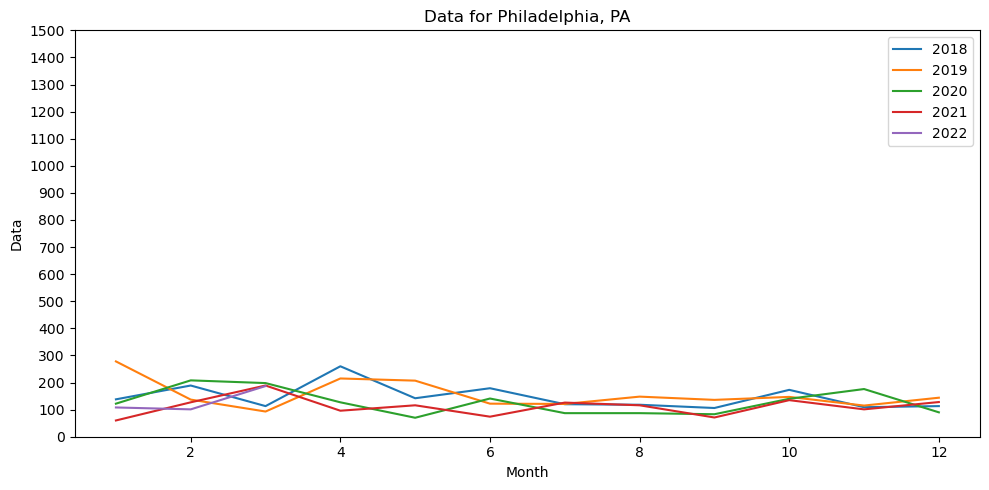

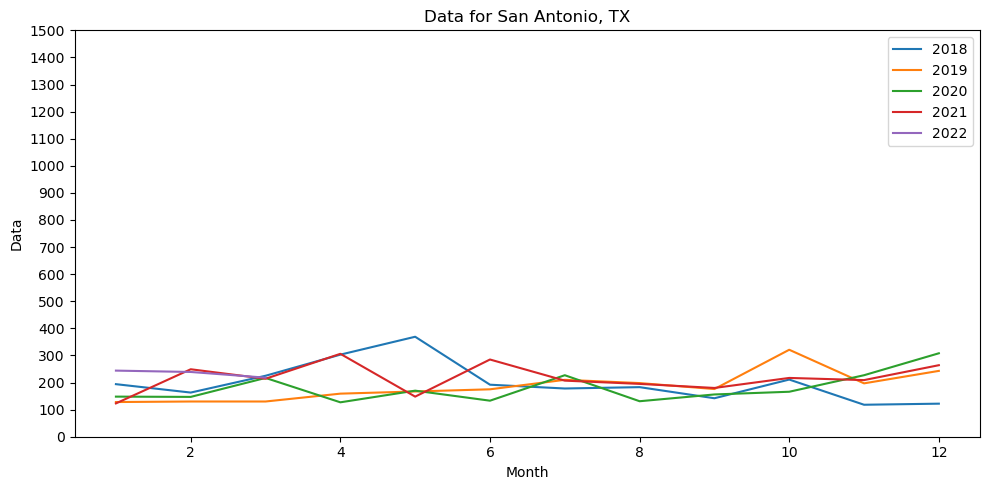

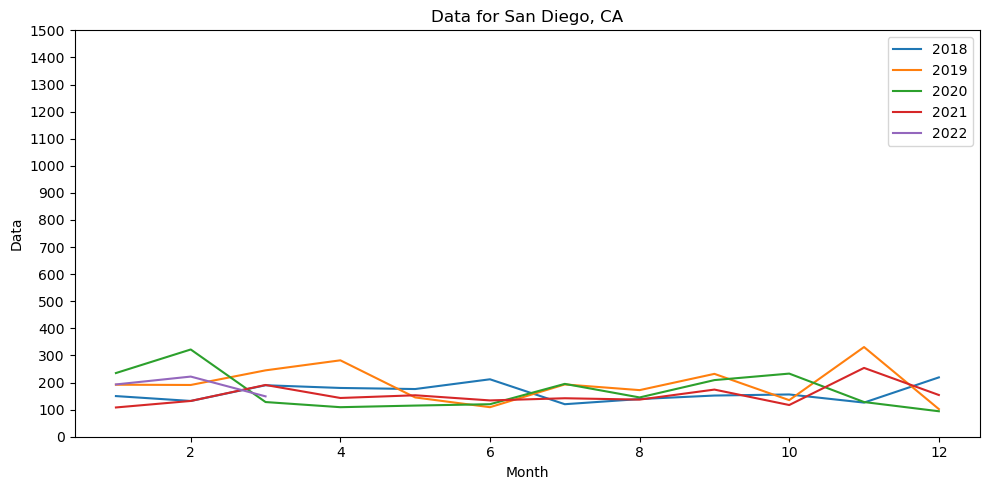

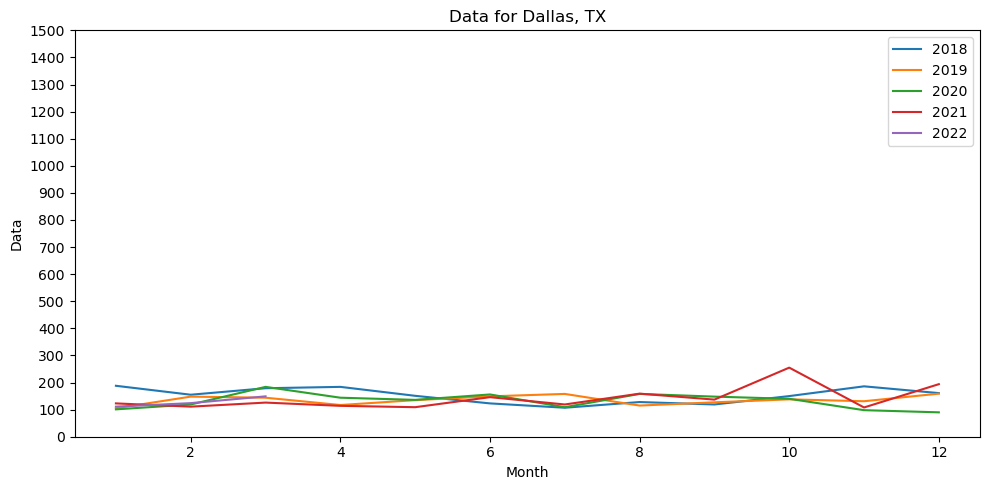

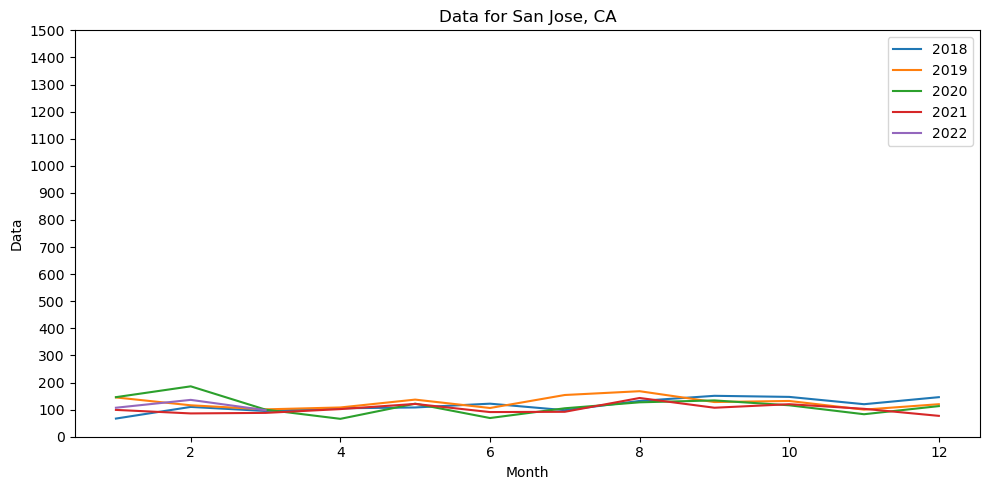

In [8]:
import matplotlib.pyplot as plt

# 获取年份列表
years = df.index.get_level_values('year').unique()

# 对每个城市进行绘制
for city in city_list:
    # 创建一个图形
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # 为每个年份绘制一条折线
    for year in years:
        # 获取该年份的数据
        df_year = df.xs(year, level='year')

        # 绘制折线
        ax.plot(df_year.index, df_year[city], label=str(year))

    # 设置标题、轴标签等
    ax.set_title(f'Data for {city}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Data')
    ax.legend()
    ax.set_yticks(np.arange(0, 1600, 100))
    plt.tight_layout()
    plt.show()


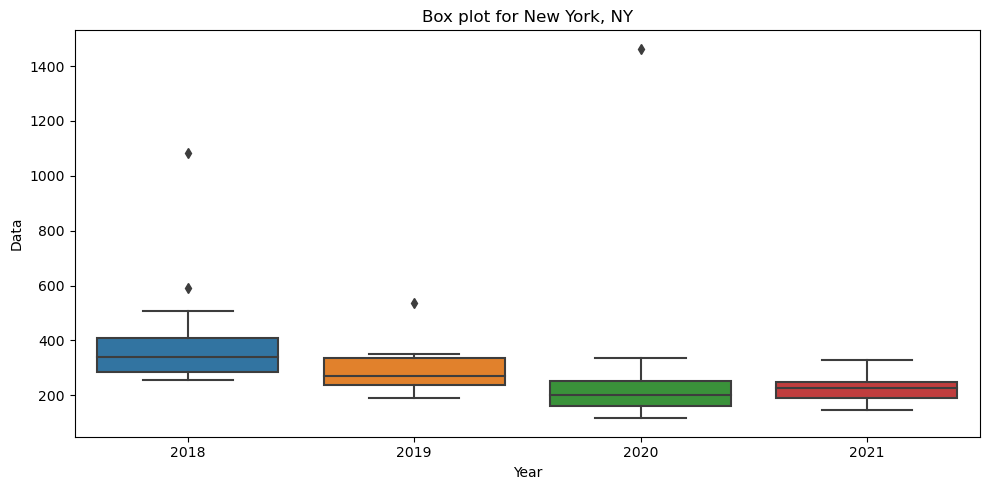

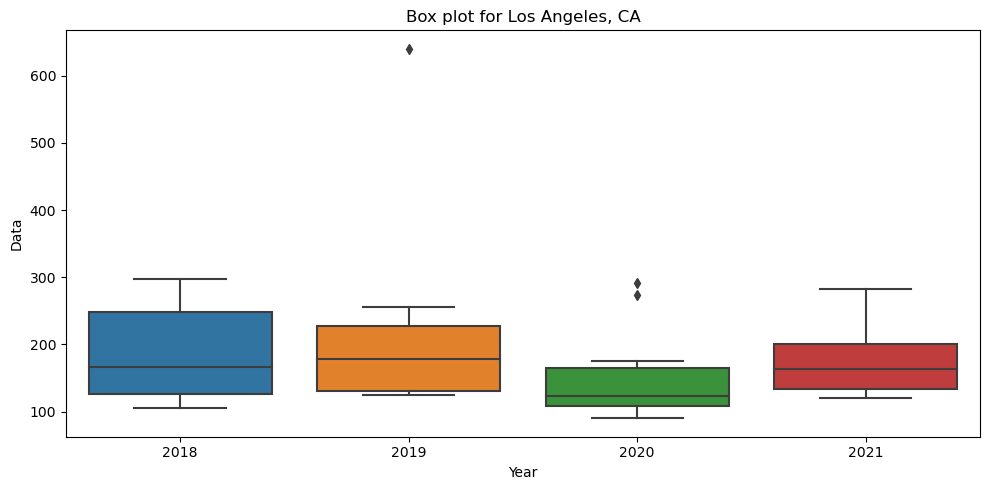

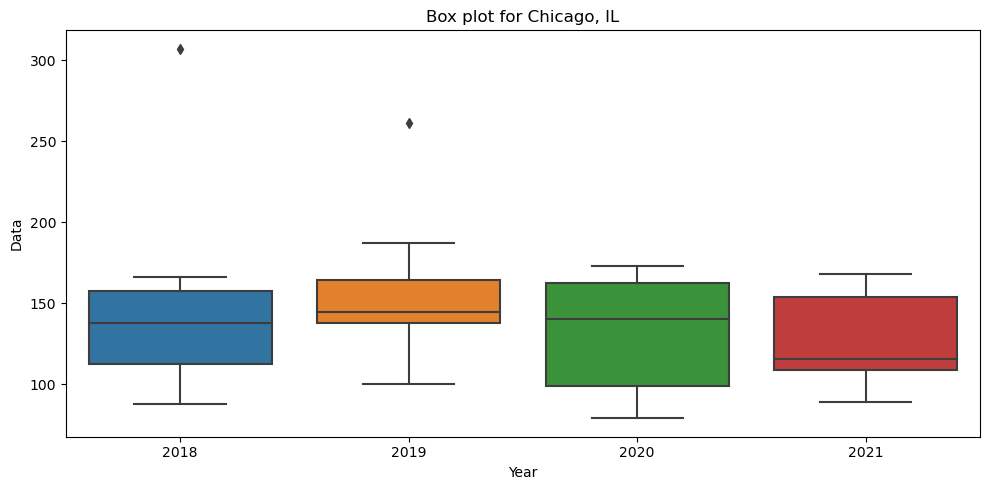

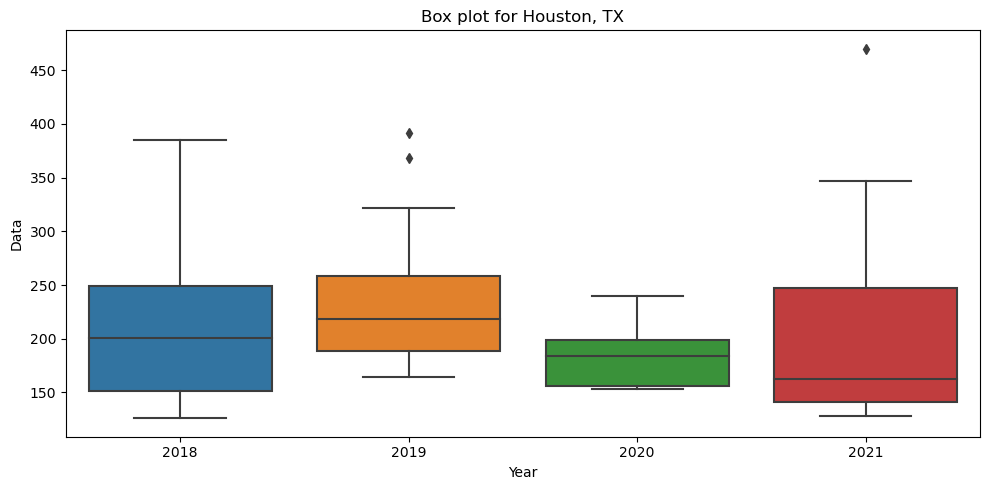

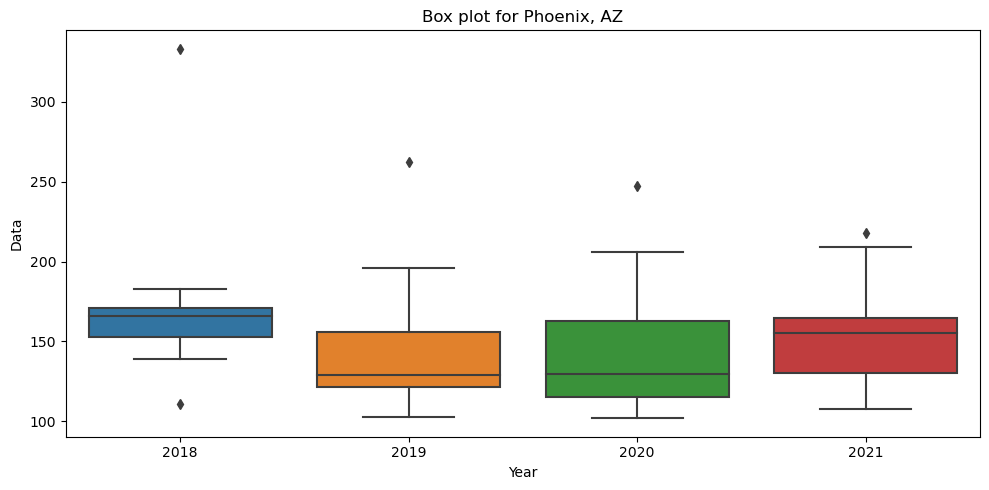

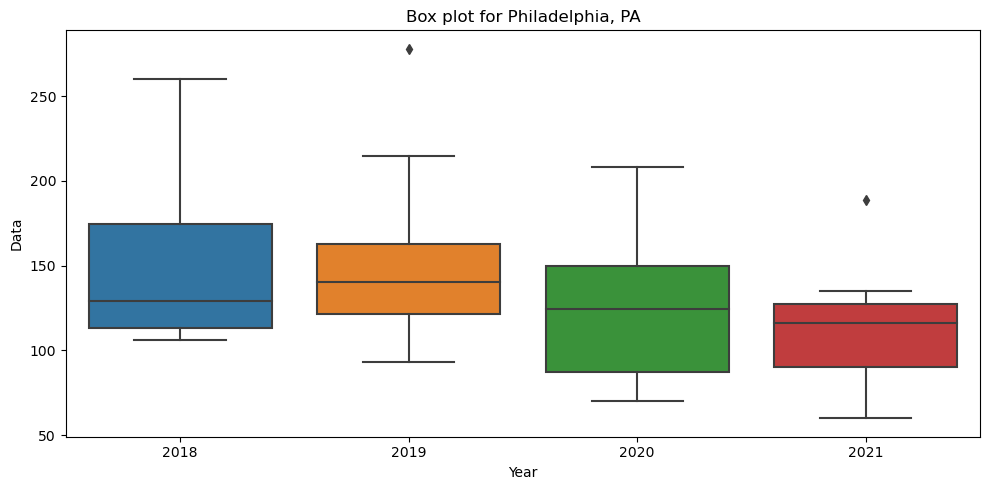

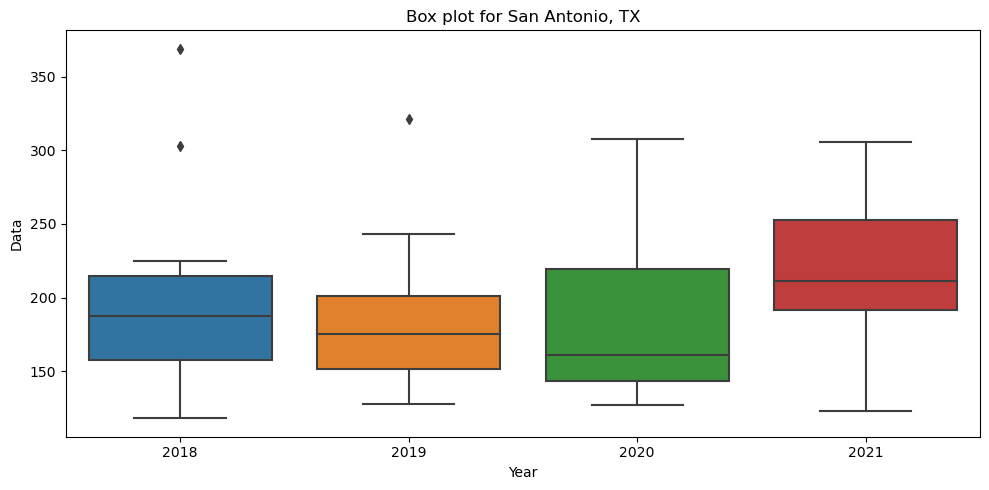

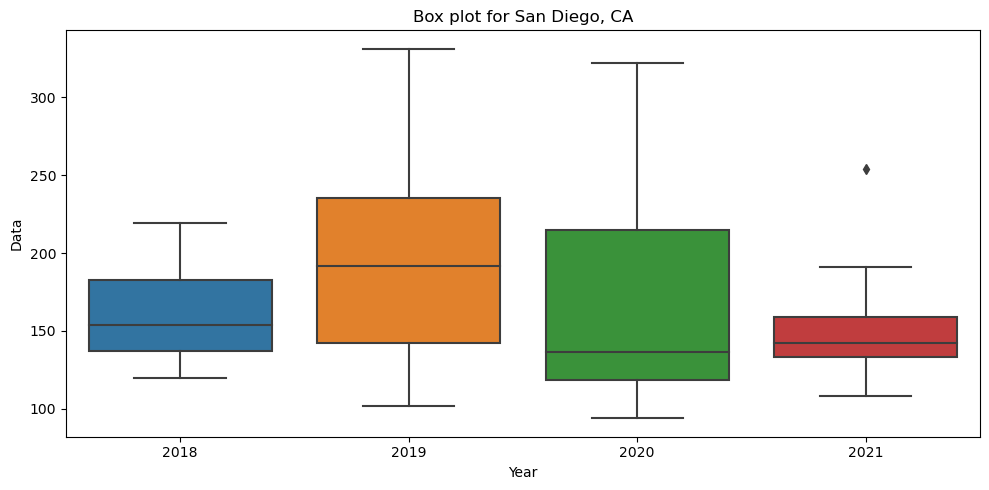

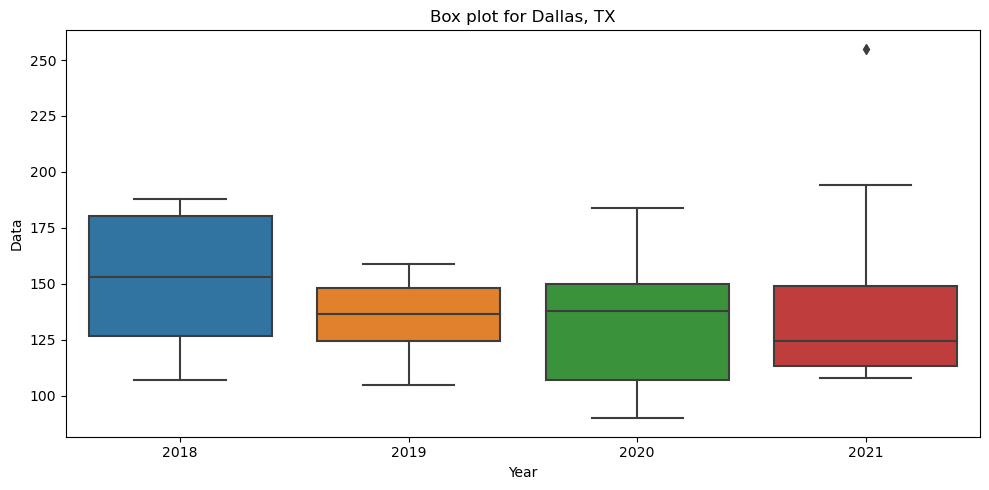

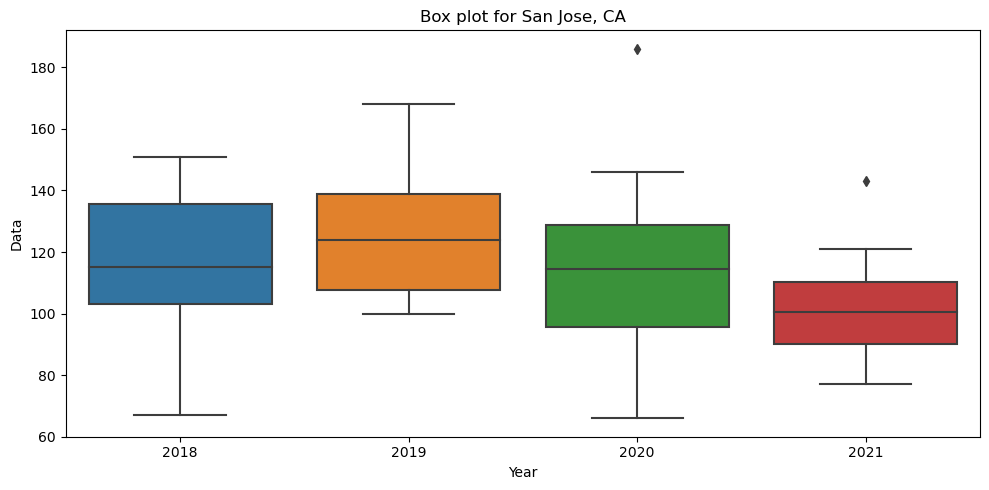

In [11]:
import seaborn as sns
# 删除 2022 年的数据
df = df[df.index.get_level_values('year') != 2022]

# 对每个城市进行绘制
for city in city_list:
    # 创建一个图形
    fig, ax = plt.subplots(figsize=(10, 5))

    # 创建一个新的数据框，其中包含年份和城市的数据
    df_city = df[city].reset_index()

    # 使用 seaborn 创建箱线图
    sns.boxplot(x='year', y=city, data=df_city, ax=ax)

    # 设置标题、轴标签等
    ax.set_title(f'Box plot for {city}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Data')

    plt.tight_layout()
    plt.show()


In [38]:
# Draw flowmaps, in whcih strongly connected components are colored differently.
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
import networkx as nx
import pickle
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.neighbors import kneighbors_graph
from matplotlib.cm import get_cmap

# Load your numpy array and node to CBG mapping
flow_matrix = np.load(r'data\Mobility\cbg_visit_2020-10_1.npy')

# Set the diagonal elements to zero
np.fill_diagonal(flow_matrix, 0)

# Load the id_dict_2.pkl
with open(r'data\Mobility\id_dict_1.pkl', 'rb') as f:
    id_dict = pickle.load(f)

# Load the Shapefile
gdf = gpd.read_file(r"arcgis project\cbgs\cbgs_of_cities\New_York_city.shp")
# Convert the WKT centroid strings into shapely Point objects
gdf['Centroid'] = gdf['Centroid'].apply(wkt.loads)

# Define function to create graph for given k
def create_graph(k):
    sorted_indices = np.argsort(-flow_matrix, axis=1)
    edges = [(i, j) for i in range(flow_matrix.shape[0]) for j in sorted_indices[i, :k]]
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G,edges


# Define function to plot flow map
def plot_flow_map(G, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')
    #nx.draw_networkx(G, pos, with_labels=False, node_size=10, ax=ax)

    pos = {node: (gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].y) for node in G.nodes()}


    # 计算连通子图
    scc = list(nx.strongly_connected_components(G))
    print(len(scc))
    # 绘制网络
    cmap = get_cmap('viridis')

    for i, component in enumerate(scc):
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_color=cmap(i / len(scc)), ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u in component for v in G.neighbors(u)], ax=ax)
    
    plt.title(title)
    plt.show()

def plot_flow_map2(graph, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')

    # Create lines for each flow
    lines = [([gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].y], 
               [gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].y]) 
              for i, j in graph]

    lc = LineCollection(lines, color='blue', linewidths=0.5)

    # Add lines to plot
    ax.add_collection(lc)

    plt.title(title)
    plt.show()
    
    
# 指定 k 值
k_values = [160, 250, 337]

for k in k_values:
    top_k_flows_G, top_k_flows_graph = create_graph(k)
    plot_flow_map(top_k_flows_G, f'Top {k} Flows in New York')
# Create all flows graph
#all_flows_graph = create_graph(flow_matrix.shape[0])

# Create top k flows graph

# Plot all flows map
#plot_flow_map(all_flows_graph, 'All Flows in Los Angeles')

# Plot top k flows map
#plot_flow_map(top_k_flows_graph, f'Top {2} Flows in Los Angeles')





FileNotFoundError: [Errno 2] No such file or directory: 'data\\Mobility\\cbg_visit_2020-10_1.npy'

In [16]:
# Calculating cbg counts for each city
cbg_counts = []
for year in range(2019, 2020):
    for month in range(1, 2):
        for city in range(1, 11):
            flow_matrix = np.load(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
            n = flow_matrix.shape[0]
            cbg_counts.append(n)


In [ ]:
# Abloshed 
# the function to find the minimum number of flows required to ensure connectivity in a network
def minimum_flows_for_connectivity(flow_matrix):
    # Initialize k
    k = 1

    # Get the number of units (assumes flow_matrix is square)
    num_units = flow_matrix.shape[0]
    np.fill_diagonal(flow_matrix, 0)
    # Create a list of indices for sorting the flows in descending order
    sorted_indices = np.argsort(-flow_matrix, axis=1)

    while True:
        # Initialize a directed graph
        G = nx.DiGraph()

        # Add all nodes to the graph
        G.add_nodes_from(range(num_units))

        # For each origin unit, add edges for the top k flows
        for origin in range(num_units):
            for destination in sorted_indices[origin, :k]:
                G.add_edge(origin, destination)

        # Check if the graph is weakly connected
        if nx.is_weakly_connected(G):
            # If it is, return the current value of k
            return k

        # If not, increment k
        k += 1
        
# Use cases of the function
"""flow_matrix = np.load(r'data\Mobility\cbg_visit_2018-01_1.npy')
k = minimum_flows_for_connectivity(flow_matrix)
print(f'The minimum number of highest flows needed to keep the graph weakly connected is {k}.')"""

"""for year in range(2018, 2023):
    for month in range(1, 13):
        for city in range(1, 11):
            flow_matrix = np.load(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
            k = minimum_flows_for_connectivity(flow_matrix)
            print("{year_}-{month_}_{city_}:{k_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city,k_=k))"""


In [ ]:
# Abloshed 
# Extracting the minimum number of highest flows needed to keep the graph weakly connected using binary search
import numpy as np
import networkx as nx

def binary_search_connectivity(flow_matrix):
    num_units = flow_matrix.shape[0]

    # Sorted indices for descending order of flow for each unit
    sorted_indices = np.argsort(-flow_matrix, axis=1)

    # Binary search variables
    low = 1
    high = num_units 
    
    # Function to create a graph for a given k
    def create_graph(k):
        G = nx.DiGraph()
        G.add_nodes_from(range(num_units))
        for origin in range(num_units):
            for destination in sorted_indices[origin, :k]:
                G.add_edge(origin, destination)
        return G

    while low < high:
        mid = low + (high - low) // 2

        # Check if the graph is weakly connected for the current mid
        if nx.is_weakly_connected(create_graph(mid)):
            high = mid
        else:
            low = mid + 1

    # Final check if the graph is weakly connected for the low/high point
    if nx.is_weakly_connected(create_graph(low)):
        return low
    else:
        return -1

# Usage:
flow_matrix = np.load('path_to_your_file.npy')
k = binary_search_connectivity(flow_matrix)
print(f'The minimum number of highest flows needed to keep the graph weakly connected is {k}.')


In [ ]:
# Grographical data preprocessing (from csv to shp)
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(r'data\Basic_Geographic_Statistics_CBG.csv')

# Convert the WKT boundary strings into shapely objects
df['Boundary'] = df['Boundary'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
# Make sure to specify the correct coordinate system for your data
gdf = gpd.GeoDataFrame(df, geometry='Boundary', crs="EPSG:4326")

# Save the GeoDataFrame as a Shapefile
gdf.to_file("output_file.shp")

In [ ]:
# Geographical data preprocessing (Split whole American CBG data to each city)
import geopandas as gpd

# Load the Shapefile
gdf = gpd.read_file(r"arcgis project\cbgs\cbgs_2018.shp")
print(gdf.info())
# Split the GeoDataFrame into multiple GeoDataFrames based on the 'City Name' column
gdfs = [data for city_name, data in gdf.groupby('City_Name')]

# Save each GeoDataFrame as a separate Shapefile
for city_gdf in gdfs:
    city_name = city_gdf['City_Name'].unique()[0]
    print(city_name)
    # The file name is based on the city name
    # Spaces are replaced with underscores and the file extension .shp is added
    filename = city_name.replace(' ', '_') + '.shp'

    #city_gdf.to_file(r"arcgis project\cbgs\{}",format(filename))
    city_gdf.to_file(filename)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18364 entries, 0 to 18363
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   City_Name   18364 non-null  object  
 1   CBG_Code    18364 non-null  float64 
 2   Year        18364 non-null  float64 
 3   Population  18364 non-null  float64 
 4   Area        18364 non-null  float64 
 5   Centroid    18364 non-null  object  
 6   Shape_Leng  18364 non-null  float64 
 7   Shape_Area  18364 non-null  float64 
 8   geometry    18364 non-null  geometry
dtypes: float64(6), geometry(1), object(2)
memory usage: 1.3+ MB
None
Chicago city
Dallas city
Houston city
Los Angeles city
New York city
Philadelphia city
Phoenix city
San Antonio city
San Diego city
San Jose city


## Extracting scripts for Guangdong data

In [ ]:
# Calculate k for Guangdong cities. Delete nodes first.
delete_degrees = [3, 6, 9, 12, 15, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,]

city_list = ['东莞市', '中山市', '云浮市', '佛山市', '广州市', '惠州市', '揭阳市', '梅州市', '汕头市',
             '汕尾市', '江门市', '河源市', '深圳市', '清远市', '湛江市', '潮州市', '珠海市', '肇庆市',
             '茂名市', '阳江市', '韶关市']

city_list_eng = ['Dongguan', 'Zhongshan', 'Yunfu', 'Foshan', 'Guangzhou', 'Huizhou', 'Jieyang',
             'Meizhou', 'Shantou', 'Shanwei', 'Jiangmen', 'Heyuan', 'Shenzhen', 'Qingyuan', 
             'Zhanjiang', 'Chaozhou', 'Zhuhai', 'Zhaoqing', 'Maoming', 'Yangjiang', 'Shaoguan']

df_ks = pd.DataFrame(columns=['delete_degree']+city_list_eng)
df_ks['delete_degree'] = delete_degrees
print(df_ks)
for city in city_list_eng:
    flow_matrix = np.load(r'.\data\Guangdong\flow_matrix\gd_flow_matrix_{}_1101-1107.npy'.format(city))
    print(city)
    results = []
    for delete_degree in delete_degrees:
        # Convert the original flows to binary
        flows_binary = (flow_matrix > 0).astype(int)

        # Calculate the degrees based on the new definition
        degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

        # find the nodes whose degree are lower than 5
        nodes_to_remove = np.where(degrees_all < delete_degree)[0]
        print('Number of nodes to remove: ', len(nodes_to_remove))

        # Remove the ndoes from the matrix
        reduced_matrix = np.delete(flow_matrix, nodes_to_remove, axis=0)
        reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

        k=minimum_flows_for_strongly_connectivity(reduced_matrix)
        results.append(k)
        df_ks.loc[df_ks['delete_degree']==delete_degree, city] = k
    print(results)
    # 绘制结果
    plt.plot(delete_degrees, results)
    plt.xlabel('Delete Degree')
    plt.ylabel('k (minimum flows for strong connectivity)')
    plt.title('Variation of k with Delete Degree in {}'.format(city))
    plt.grid(True)
    plt.show()
    plt.close()

df_ks.to_csv('k_select_Guangdong.csv')

In [ ]:
# Calculate k for Guangdong cities. Extracting the largest strongly connected component first.
delete_degrees = [3, 6, 9, 12, 15, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,]

city_list = ['东莞市', '中山市', '云浮市', '佛山市', '广州市', '惠州市', '揭阳市', '梅州市', '汕头市',
             '汕尾市', '江门市', '河源市', '深圳市', '清远市', '湛江市', '潮州市', '珠海市', '肇庆市',
             '茂名市', '阳江市', '韶关市']

city_list_eng = ['Dongguan', 'Zhongshan', 'Yunfu', 'Foshan', 'Guangzhou', 'Huizhou', 'Jieyang',
             'Meizhou', 'Shantou', 'Shanwei', 'Jiangmen', 'Heyuan', 'Shenzhen', 'Qingyuan', 
             'Zhanjiang', 'Chaozhou', 'Zhuhai', 'Zhaoqing', 'Maoming', 'Yangjiang', 'Shaoguan']

df_ks = pd.DataFrame(columns=['delete_degree']+city_list_eng)
df_ks['delete_degree'] = delete_degrees

for city in city_list_eng:
    flow_matrix = np.load(r'.\data\Guangdong\flow_matrix\gd_flow_matrix_{}_1101-1107.npy'.format(city))
    print(city)
    ks = minimum_flows_for_strongly_connectivity_extract_component_first(flow_matrix)
    df_ks.loc[:, city] = ks

df_ks.to_csv('k_select_Guangdong.csv')

In [ ]:
# Build a dictionary to map the English name of the city to the Chinese name of the city in Guangdong province
city_mapping = {
    '东莞市': 'Dongguan',
    '中山市': 'Zhongshan',
    '云浮市': 'Yunfu',
    '佛山市': 'Foshan',
    '广州市': 'Guangzhou',
    '惠州市': 'Huizhou',
    '揭阳市': 'Jieyang',
    '梅州市': 'Meizhou',
    '汕头市': 'Shantou',
    '汕尾市': 'Shanwei',
    '江门市': 'Jiangmen',
    '河源市': 'Heyuan',
    '深圳市': 'Shenzhen',
    '清远市': 'Qingyuan',
    '湛江市': 'Zhanjiang',
    '潮州市': 'Chaozhou',
    '珠海市': 'Zhuhai',
    '肇庆市': 'Zhaoqing',
    '茂名市': 'Maoming',
    '阳江市': 'Yangjiang',
    '韶关市': 'Shaoguan'
}

def rename_file_with_english_city(filename):
    new_name = filename
    for cn_city, en_city in city_mapping.items():
        new_name = new_name.replace(cn_city, en_city)
    return new_name

# Rename the files in the folder
for old_filename in os.listdir(r'.\data\Guangdong\flow_matrix'):
    new_filename = rename_file_with_english_city(old_filename)
    if old_filename != new_filename:  # 检查文件名是否已更改
        os.rename(os.path.join(r'.\data\Guangdong\flow_matrix',old_filename), os.path.join(r'.\data\Guangdong\flow_matrix',new_filename))
        print(f'Renamed: {old_filename} -> {new_filename}')


## Tool Functions

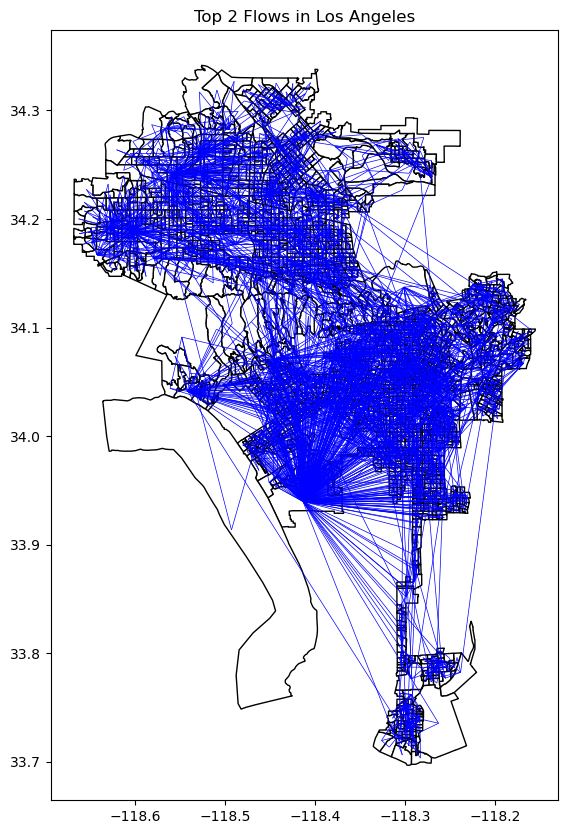

In [ ]:
# Draw a flowmap for top-k network

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
import networkx as nx
import pickle
from matplotlib.collections import LineCollection


# Load your numpy array and node to CBG mapping
flow_matrix = np.load(r'data\Mobility\cbg_visit_2022-02_2.npy')

# Set the diagonal elements to zero
np.fill_diagonal(flow_matrix, 0)

# Load the id_dict_2.pkl
with open(r'data\Mobility\id_dict_2.pkl', 'rb') as f:
    id_dict = pickle.load(f)

# Load the Shapefile
gdf = gpd.read_file(r"arcgis project\cbgs\cbgs_of_cities\Los_Angeles_city.shp")

# Convert the WKT centroid strings into shapely Point objects
gdf['Centroid'] = gdf['Centroid'].apply(wkt.loads)

# Define function to create graph for given k
def create_graph(k):
    sorted_indices = np.argsort(-flow_matrix, axis=1)
    edges = [(i, j) for i in range(flow_matrix.shape[0]) for j in sorted_indices[i, :k]]
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G,edges

# Create all flows graph
#all_flows_graph = create_graph(flow_matrix.shape[0])

# Create top k flows graph
top_k_flows_G, top_k_flows_graph = create_graph(2)

# Define function to plot flow map
def plot_flow_map(G, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')

    pos = {node: (gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].y) for node in G.nodes()}
    nx.draw_networkx(G, pos, with_labels=False, node_size=10, ax=ax)

    plt.title(title)
    plt.show()

def plot_flow_map2(graph, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')

    # Create lines for each flow
    lines = [([gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].y], 
               [gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].y]) 
              for i, j in graph]

    lc = LineCollection(lines, color='blue', linewidths=0.5)

    # Add lines to plot
    ax.add_collection(lc)

    plt.title(title)
    plt.show()

# Plot all flows map
#plot_flow_map(all_flows_graph, 'All Flows in Los Angeles')

# Plot top k flows map
plot_flow_map2(top_k_flows_graph, f'Top {2} Flows in Los Angeles')


In [ ]:
# Extract the strongly connected components and print them.
# Used for test.

# Load your numpy array and node to CBG mapping
#flow_matrix = np.load(r'data\Mobility\cbg_visit_2022-02_3.npy')
flow_matrix = np.load(r'gd_flow_matrix_1101-1107.npy')
# Set the diagonal elements to zero
np.fill_diagonal(flow_matrix, 0)

# Create directed graph from flow matrix
G = nx.nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

# Find all strongly connected components
scc = list(nx.strongly_connected_components(G))

# Print the strongly connected components
for i, component in enumerate(scc, start=1):
    print(f"Strongly connected component {i}: {component}")


# Deprecated

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd

def minimum_flows_for_strongly_connectivity_2_percent(flow_matrix):
    """The algorithm to find the smallest k such that the subgraph remains strongly connected
       after removing the nodes with the smallest 2% degree.
       
    Args:
        flow_matrix (numpy array): Flow matrix of the graph.

    Returns:
        ks: List of the smallest k for each threshold such that the subgraph remains strongly connected.
    """
    ks = []
    # Function to check if the graph is strongly connected when only top k edges are kept for each node
    def check_strongly_connected_k(graph, k):
        # Create a new graph which only keeps top k outgoing edges for each node
        new_graph = nx.DiGraph()
        for node in graph.nodes():
            edges = sorted(graph.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
            new_graph.add_edges_from(edges)
        # Check if the new graph is still strongly connected
        return nx.is_strongly_connected(new_graph)
    
    # Set the diagonal elements to zero
    np.fill_diagonal(flow_matrix, 0)

    # Create directed graph from flow matrix
    G = nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

    # Find all strongly connected components
    scc = list(nx.strongly_connected_components(G))
    
    # Create a subgraph with only nodes in the first SCC
    strongly_connected_G = G.subgraph(max(scc, key=len))
    
    # Convert graph to numpy adjacency matrix
    adj_matrix = nx.adjacency_matrix(strongly_connected_G)
    numpy_array = adj_matrix.toarray()
    # Convert the original flows to binary
    flows_binary = (numpy_array > 0).astype(int)
    # Calculate the degrees based on the new definition
    degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

    # Determine the 2% degree threshold
    percentile_2_threshold = np.percentile(degrees_all, 2)

    # find the nodes whose degree are in the lowest 2%
    nodes_to_remove = np.where(degrees_all <= percentile_2_threshold)[0]
    print('Number of nodes to remove: ', len(nodes_to_remove))

    # Remove the nodes from the matrix
    reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
    reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

    # Create directed graph from the reduced matrix
    sub_G = nx.from_numpy_array(reduced_matrix, create_using=nx.DiGraph)
    
    # Find all strongly connected components
    scc = list(nx.strongly_connected_components(sub_G))
    
    # Create a subgraph with only nodes in the first SCC
    sub_G = sub_G.subgraph(max(scc, key=len))
    
    print("nodes of the largest strongly connected graph for city:", len(sub_G.nodes()))
    num_units = len(sub_G.nodes())

    # Binary search variables
    low = 1
    high = num_units

    while low < high:
        mid = low + (high - low) // 2

        # Check if the graph is strongly connected for the current mid
        if check_strongly_connected_k(sub_G, mid):
            high = mid
        else:
            low = mid + 1

    # Final check if the graph is strongly connected for the low/high point
    if  check_strongly_connected_k(sub_G, low):
        print(low)
        ks.append(low)
    else:
        print(-1)
        ks.append(-1)

    return ks
